![UBA](assets/UBA_header_black.png)

# Dataset seleccionado: BA Ecobici
Contiene información sobre los viajes realizados a través del servicio público de bicicletas BA Ecobici, que opera en la Ciudad Autónoma de Buenos Aires.

In [2]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import requests
import zipfile
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import folium

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Ingesta de los datos

In [ ]:
USUARIOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_usuarios_2024.csv"
RECORRIDOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_recorridos_realizados_2024.zip"
USUARIOS_CSV = pathlib.Path("./datasets/badata_ecobici_usuarios_2024.csv")
RECORRIDOS_ZIP = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.zip")
RECORRIDOS_CSV = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.csv")

# Descarga de los archivos
GET_FILES = False

if GET_FILES:
    def download_file(url, dest_path):
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(dest_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)


    download_file(USUARIOS_FILE_URL, USUARIOS_CSV)
    download_file(RECORRIDOS_FILE_URL, RECORRIDOS_ZIP)

    with zipfile.ZipFile(RECORRIDOS_ZIP) as zip_ref:
        zip_contents = zip_ref.namelist()
        if zip_contents:
            zip_ref.extract(zip_contents[0], path=RECORRIDOS_CSV.parent)
            extracted_file = RECORRIDOS_CSV.parent / zip_contents[0]
            extracted_file.rename(RECORRIDOS_CSV)

    RECORRIDOS_ZIP.unlink()


'USUARIOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_usuarios_2024.csv"\nRECORRIDOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_recorridos_realizados_2024.zip"\nUSUARIOS_CSV = pathlib.Path("./datasets/badata_ecobici_usuarios_2024.csv")\nRECORRIDOS_ZIP = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.zip")\nRECORRIDOS_CSV = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.csv")\n\n# Descarga de los archivos\nGET_FILES = False\n\nif GET_FILES:\n    def download_file(url, dest_path):\n        response = requests.get(url, stream=True)\n        response.raise_for_status()\n        with open(dest_path, \'wb\') as f:\n            for chunk in response.iter_content(chunk_size=8192):\n                f.write(chunk)\n\n\n    download_file(USUARIOS_FILE_URL, USUARIOS_CSV)\n    download_fil

In [ ]:
users_df = pd.read_csv(USUARIOS_CSV)
rides_df = pd.read_csv(RECORRIDOS_CSV)

In [ ]:
"""users_df = pd.read_csv("datasets/usuarios_2024.csv")
rides_df = pd.read_csv("datasets/recorridos_realizados_2024.csv")"""

# Hipótesis
- Los fines de semana hay una mayor cantidad de usuarios nuevos
- Los fines de semana se realizan más recorridos
- Las estaciones ubicadas cerca de centros de transbordo (trenes, subtes y colectivos) son las más utilizadas
- La mayoría de los viajes ocurre en horas pico laborales
- La duración promedio de los recorridos es mayor los fines de semana
- Las estaciones ubicadas en zonas comerciales son más usadas en horario laboral
- En invierno disminuye la cantidad de viajes

# Posibilidades abiertas para el futuro
Si bien no forman parte del objetivo actual, este análisis podría extenderse utilizando modelos de aprendizaje automático para:
- Predecir demanda futura por estación
- Estimar la duración de un recorrido en función del día y hora de inicio <br>
<br>
Para esto, se podría cruzar con otros datasets:
- BA Ecobici (de años anteriores y posteriores)
- Clima (Servicio Metereológico Nacional)
- Transporte público (datos de viajes en otros medios de transporte)
- Eventos masivos (recitales, eventos deportivos, eventos gratuitos del GCBA, etc.)

# Dataset de usuarios (CSV)
Contiene el listado de usuarios del servicio, que se dieron de alta en 2024.

In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197079 entries, 0 to 197078
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_usuario      197079 non-null  int64 
 1   genero_usuario  197079 non-null  object
 2   edad_usuario    197079 non-null  int64 
 3   fecha_alta      197079 non-null  object
 4   hora_alta       197079 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB


In [6]:
users_df.head()

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,1083579,OTHER,23,2024-01-01,01:59:02
1,1083608,OTHER,36,2024-01-01,02:55:46
2,1083612,OTHER,38,2024-01-01,03:13:15
3,1083616,FEMALE,21,2024-01-01,03:40:54
4,1083631,MALE,36,2024-01-01,05:02:35


In [7]:
users_df.describe()

,id_usuario,edad_usuario
count,1.970790e+05,197079.000000
mean,1.182078e+06,30.764521
std,5.689283e+04,18.896208
min,1.083538e+06,4.000000
25%,1.132808e+06,21.000000
50%,1.182078e+06,27.000000
75%,1.231348e+06,37.000000
max,1.280619e+06,2021.000000


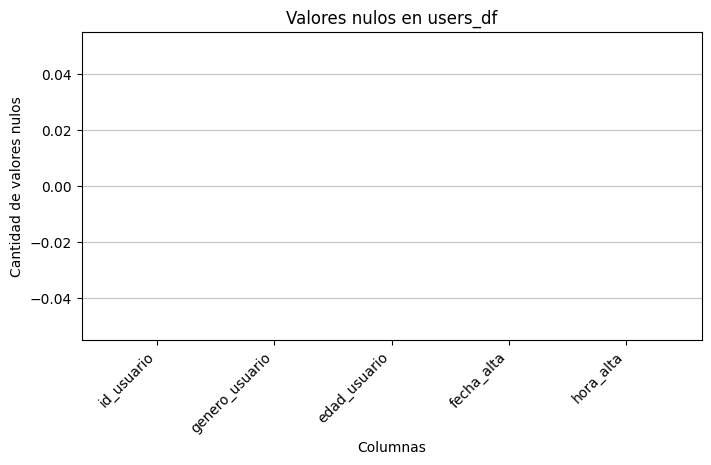

In [8]:
# Exploración de valores nulos
plt.figure(figsize=(8, 4))
plt.grid(axis='y', alpha=0.75)
plt.bar(users_df.columns, users_df.isnull().sum(), align='center', zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en users_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

In [9]:
# Usuarios duplicados
duplicated_users = users_df[users_df.duplicated(subset='id_usuario', keep=False)]
print(f"Cantidad de usuarios duplicados: {duplicated_users['id_usuario'].nunique()}")
duplicated_users.sort_values(by='id_usuario').head(10)

Cantidad de usuarios duplicados: 0


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta


##### Exploración de generos

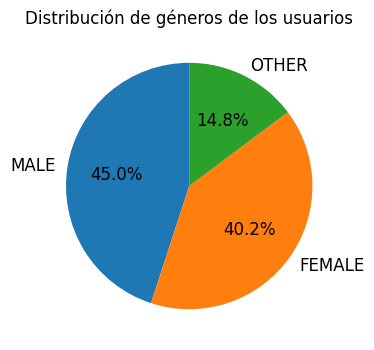

In [10]:
# Pie chart de los géneros de usuarios
plt.figure(figsize=(4, 4))
users_df['genero_usuario'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de los usuarios')
plt.ylabel('')
plt.show()

In [11]:
# Conteo de usuarios por género
gender_counts = users_df['genero_usuario'].value_counts()
print(gender_counts)

genero_usuario
MALE      88656
FEMALE    79310
OTHER     29113
Name: count, dtype: int64


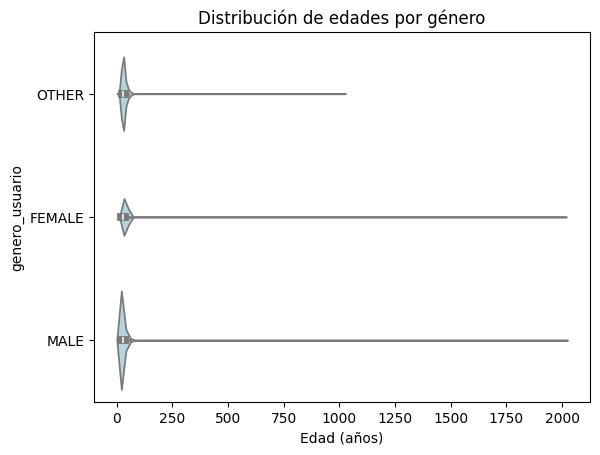

In [12]:
sns.violinplot(y=users_df['genero_usuario'], x=users_df['edad_usuario'], color='lightblue', inner='box')
plt.title('Distribución de edades por género')
plt.xlabel('Edad (años)')
plt.show()

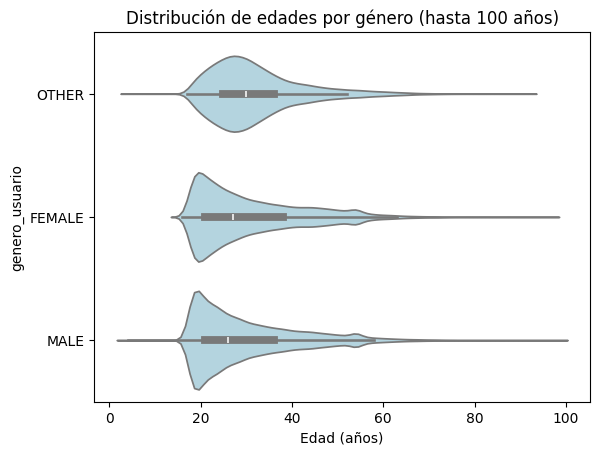

In [13]:
# Violin de edades por género (edades hasta 100 años)
mask_edad = users_df['edad_usuario'] <= 100
sns.violinplot(y=users_df['genero_usuario'][mask_edad], x=users_df['edad_usuario'][mask_edad], color='lightblue', inner='box')
plt.title('Distribución de edades por género (hasta 100 años)')
plt.xlabel('Edad (años)')
plt.show()

##### Exploración de edades

In [14]:
# Edades de usuarios menores de 18 años
users_df[users_df['edad_usuario'] < 18].value_counts('edad_usuario').sort_index()

edad_usuario
4      2
5      4
15     3
16     7
17    16
Name: count, dtype: int64

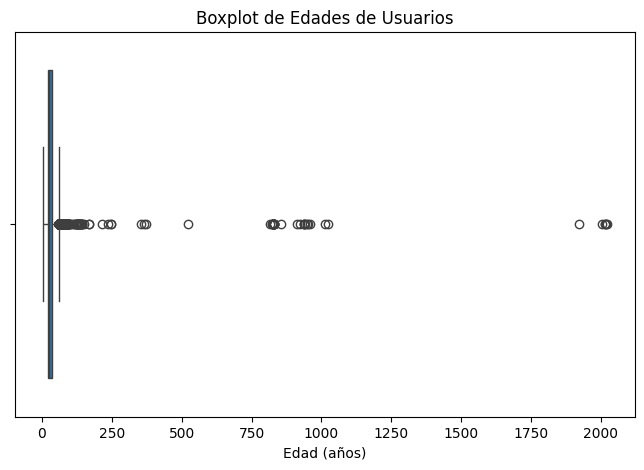

In [15]:
# Boxplot de edades
plt.figure(figsize=(8, 5))
sns.boxplot(x=users_df['edad_usuario'])
plt.title('Boxplot de Edades de Usuarios')
plt.xlabel('Edad (años)')
plt.show()

In [16]:
# Cuartiles en años
Q1 = users_df['edad_usuario'].quantile(0.25)
Q2 = users_df['edad_usuario'].quantile(0.50)
Q3 = users_df['edad_usuario'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 (25%):", Q1)
print("Q2 (Mediana, 50%):", Q2)
print("Q3 (75%):", Q3)
print("IQR (Rango Intercuartílico):", IQR)

Q1 (25%): 21.0
Q2 (Mediana, 50%): 27.0
Q3 (75%): 37.0
IQR (Rango Intercuartílico): 16.0


In [17]:
# Media moda mediana de edades (en años)
mean = users_df['edad_usuario'].mean().round(2)
median = users_df['edad_usuario'].median().round(2)
mode = users_df['edad_usuario'].mode()[0].round(2)
var = users_df['edad_usuario'].var().round(2)
std_dev = users_df['edad_usuario'].std().round(2)

print(f"Media: {mean} años")
print(f"Mediana: {median} años")
print(f"Moda: {mode} años")
print(f"Varianza: {var} años²")
print(f"Desviación estándar: {std_dev} años")

Media: 30.76 años
Mediana: 27.0 años
Moda: 18 años
Varianza: 357.07 años²
Desviación estándar: 18.9 años


In [18]:
print(f"Asímetría de edad: {users_df['edad_usuario'].skew()}")
print(f"Curtosis de edad: {users_df['edad_usuario'].kurtosis()}")

Asímetría de edad: 47.583628237635786
Curtosis de edad: 4173.90573483157


La edad de usuario es altamente asimétrica:
- Tiene muchos valores bajos
- Tiene pocos valores extremadamente altos (estiran la cola a derecha)

La edad de usuario tiene una curtosis muy alta:
- Tiene una distribución 'picuda'
- Tiene una cola bien pesada

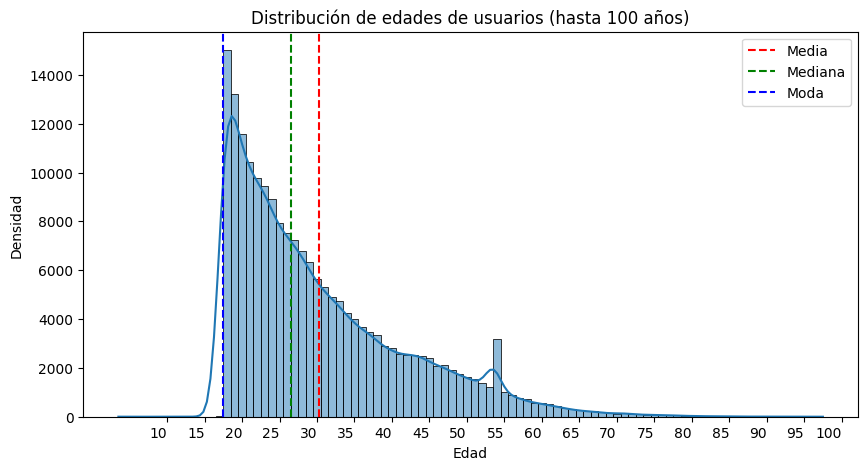

In [19]:
# Histograma de edades (hasta 100 años)
mask_edad = users_df['edad_usuario'] <= 100
plt.figure(figsize=(10, 5))
ax = sns.histplot(users_df[mask_edad]['edad_usuario'], kde=True, binwidth=1)
ticks = [t + 0.5 for t in range(10, 101, 5)]  # Esto es para centrar los bines en los ticks
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels([str(int(tick)) for tick in ticks], ha='right')
plt.title('Distribución de edades de usuarios (hasta 100 años)')
plt.xlabel('Edad')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()


Text(0, 0.5, 'Densidad')

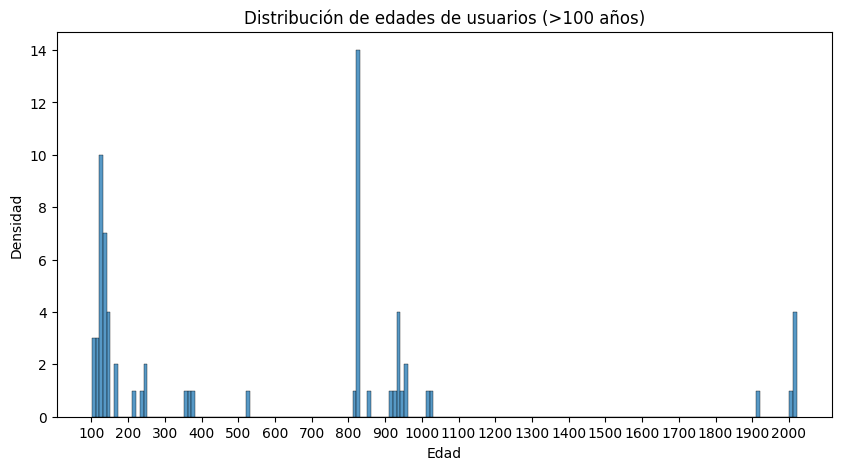

In [20]:
# Histograma de edades de mas de 100 años
mask_edad = users_df["edad_usuario"] > 100
plt.figure(figsize=(10, 5))
sns.histplot(users_df[mask_edad]['edad_usuario'], binwidth=10)
plt.title('Distribución de edades de usuarios (>100 años)')
plt.xticks(range(100, users_df['edad_usuario'].max() + 1, 100))
plt.xlabel('Edad')
plt.ylabel('Densidad')

In [21]:
# 10 usuarios mas 'viejos'
users_df.sort_values(by='edad_usuario', ascending=False).head(10)

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
56690,1109473,MALE,2021,2024-02-11,20:24:45
104417,1238144,MALE,2019,2024-10-27,20:08:47
124365,1130915,FEMALE,2016,2024-03-21,21:19:50
184254,1202670,MALE,2016,2024-09-07,18:39:34
66885,1189702,FEMALE,2004,2024-08-09,22:34:35
10936,1150325,FEMALE,1921,2024-04-29,13:33:57
137312,1277262,OTHER,1022,2024-12-27,13:11:42
62421,1167228,MALE,1012,2024-06-16,15:20:11
18616,1199423,OTHER,960,2024-09-02,17:37:56
92904,1279416,OTHER,952,2024-12-30,09:20:27


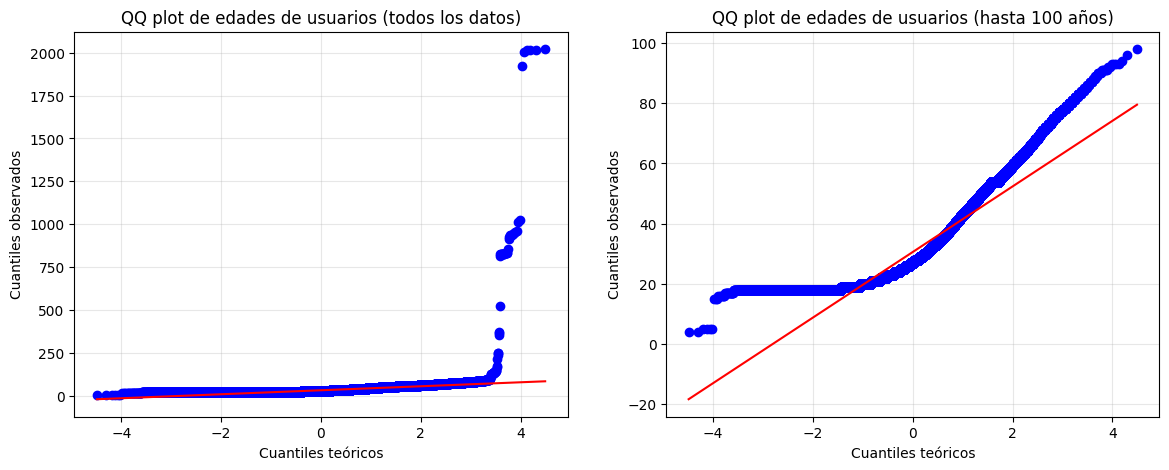

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# QQ plot con todos los datos de edad
stats.probplot(users_df['edad_usuario'], dist="norm", plot=ax1)
ax1.set_title('QQ plot de edades de usuarios (todos los datos)', fontsize=12)
ax1.set_xlabel('Cuantiles teóricos')
ax1.set_ylabel('Cuantiles observados')
ax1.grid(alpha=0.3)

# QQ plot solo con edades hasta 100 años
mask_edad = users_df['edad_usuario'] <= 100
stats.probplot(users_df[mask_edad]['edad_usuario'], dist="norm", plot=ax2)
ax2.set_title('QQ plot de edades de usuarios (hasta 100 años)', fontsize=12)
ax2.set_xlabel('Cuantiles teóricos')
ax2.set_ylabel('Cuantiles observados')
ax2.grid(alpha=0.3)

plt.show()

El QQ plot muestra
- Clara desviación respecto a la normalidad
- Cola pesada
- Muchas edades pequeñas y pocas edades muy grandes

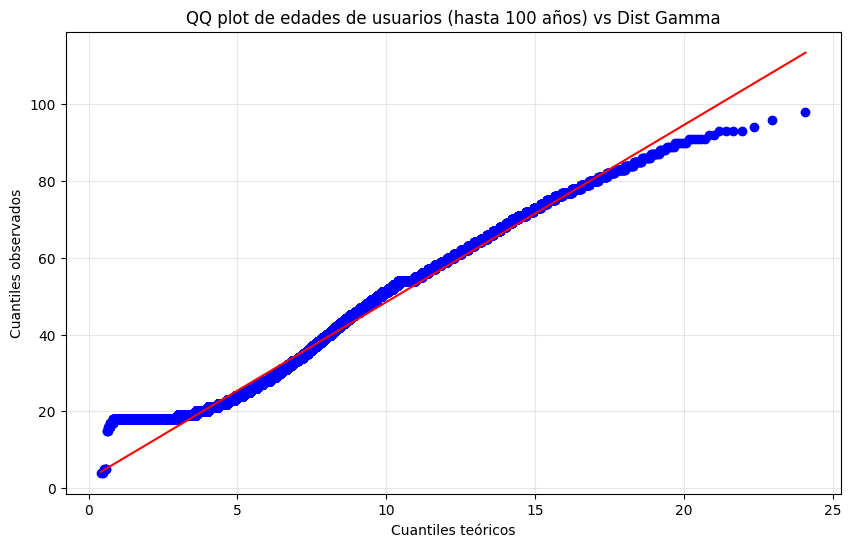

In [23]:
# QQ plot contra distribución Gamma
mask_edad = users_df['edad_usuario'] <= 100

a, loc, scale = stats.gamma.fit(users_df[mask_edad]['edad_usuario'])

fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(users_df[mask_edad]['edad_usuario'], dist=stats.gamma, sparams=(a,), plot=ax)
ax.set_title('QQ plot de edades de usuarios (hasta 100 años) vs Dist Gamma', fontsize=12)
ax.set_xlabel('Cuantiles teóricos')
ax.set_ylabel('Cuantiles observados')
ax.grid(alpha=0.3)
plt.show()

##### Exploración de fecha y hora de alta

In [24]:
# Parseo de columnas de fecha y hora
users_df['fecha_alta_dt'] = pd.to_datetime(users_df['fecha_alta'], errors='coerce')
users_df['hora_alta_dt'] = pd.to_datetime(users_df['hora_alta'], format='%H:%M:%S', errors='coerce').dt.time
users_df['dia_semana'] = users_df['fecha_alta_dt'].dt.day_name()

In [25]:
# 10 fechas de alta mas repetidas
users_df['fecha_alta_dt'].value_counts().head(10)

fecha_alta_dt
2024-11-09    1720
2024-05-09    1315
2024-10-11    1278
2024-09-29    1197
2024-10-27    1154
2024-11-10    1128
2024-11-18    1119
2024-09-08    1076
2024-01-24    1062
2024-09-15    1041
Name: count, dtype: int64

In [26]:
# 10 horas de alta mas repetidas
users_df['hora_alta_dt'].apply(lambda x: x.hour).value_counts().head(10)

hora_alta_dt
16    18531
15    17762
17    17386
14    15614
18    14997
13    14042
12    13425
11    11756
19    11261
10     8984
Name: count, dtype: int64

In [27]:
# Altas por dia de la semana
users_df['dia_semana'].value_counts()

dia_semana
Sunday       31073
Saturday     28801
Monday       28599
Thursday     27978
Friday       27115
Tuesday      26841
Wednesday    26672
Name: count, dtype: int64

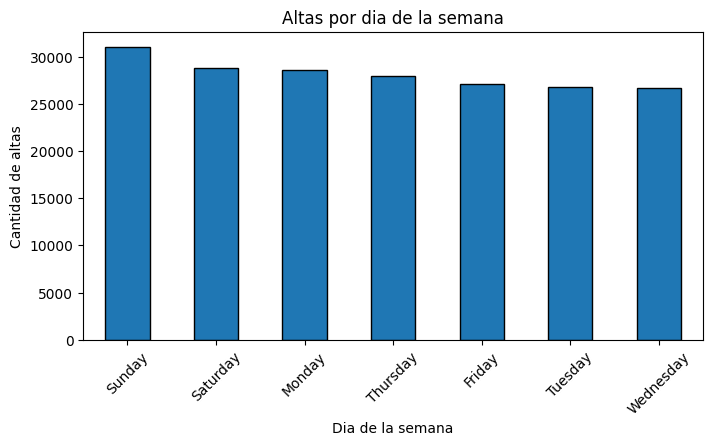

In [28]:
# Bar chart de altas por dia de la semana
plt.figure(figsize=(8, 4))
users_df['dia_semana'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Altas por dia de la semana')
plt.xlabel('Dia de la semana')
plt.ylabel('Cantidad de altas')
plt.xticks(rotation=45)
plt.show()

# Dataset de recorridos (CSV)
Contiene información de los viajes realizados.

In [29]:
rides_df.info()
# duracion_recorrido está en segundos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560404 entries, 0 to 3560403
Data columns (total 17 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id_recorrido                int64  
 1   duracion_recorrido          int64  
 2   fecha_origen_recorrido      object 
 3   id_estacion_origen          int64  
 4   nombre_estacion_origen      object 
 5   direccion_estacion_origen   object 
 6   long_estacion_origen        float64
 7   lat_estacion_origen         float64
 8   fecha_destino_recorrido     object 
 9   id_estacion_destino         int64  
 10  nombre_estacion_destino     object 
 11  direccion_estacion_destino  object 
 12  long_estacion_destino       float64
 13  lat_estacion_destino        float64
 14  id_usuario                  float64
 15  modelo_bicicleta            object 
 16  genero                      object 
dtypes: float64(5), int64(4), object(8)
memory usage: 461.8+ MB


In [30]:
rides_df.head()

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
0,24496816,17,2024-12-31 08:18:58,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,2024-12-31 08:19:15,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,1166678.0,FIT,FEMALE
1,24492524,2,2024-12-30 19:21:45,251,388 - Plaza Jose C Paz,Dr. Prof. Pedro Chutro 2881,-58.402483,-34.641728,2024-12-30 19:21:47,41,041 - PARQUE PATRICIOS II,Av Caseros 3015,-58.405888,-34.637123,1133415.0,FIT,FEMALE
2,24493951,0,2024-12-30 21:08:03,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,NaN,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,1158360.0,ICONIC,FEMALE
3,24494848,6575,2024-12-30 23:22:17,177,177 -PLANETARIO,Av. Belisario Roldán y Av. Sarmiento,-58.411598,-34.571079,2024-12-31 01:11:52,336,207 - PLAZA ARENALES,Nueva York 3949,-58.511146,-34.599731,1224331.0,FIT,FEMALE
4,24495039,3162,2024-12-30 23:52:00,359,250 - Fleni,2292 Montañeses,-58.450479,-34.555602,2024-12-31 00:44:42,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,1280053.0,ICONIC,FEMALE


In [31]:
rides_df.describe()

,id_recorrido,duracion_recorrido,id_estacion_origen,long_estacion_origen,lat_estacion_origen,id_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario
count,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06
mean,2.234132e+07,1.274680e+03,2.355957e+02,-5.842302e+01,-3.459877e+01,2.371506e+02,-5.842318e+01,-3.459896e+01,7.908728e+05
std,1.257073e+06,9.582717e+03,1.657999e+02,3.830469e-02,2.441487e-02,1.657100e+02,3.848631e-02,2.477407e-02,3.881981e+05
min,2.018097e+07,0.000000e+00,2.000000e+00,-5.852710e+01,-3.468777e+01,2.000000e+00,-5.852710e+01,-3.468777e+01,2.400000e+01
25%,2.123866e+07,4.930000e+02,9.300000e+01,-5.844965e+01,-3.461635e+01,9.600000e+01,-5.844966e+01,-3.461649e+01,5.118240e+05
50%,2.235131e+07,8.810000e+02,1.990000e+02,-5.842095e+01,-3.460028e+01,2.000000e+02,-5.842095e+01,-3.460075e+01,9.131670e+05
75%,2.343700e+07,1.473000e+03,3.780000e+02,-5.839374e+01,-3.458255e+01,3.790000e+02,-5.839374e+01,-3.458234e+01,1.113537e+06
max,2.450328e+07,2.571165e+06,5.770000e+02,-5.835547e+01,-3.453669e+01,5.770000e+02,-5.835547e+01,-3.453669e+01,1.280599e+06


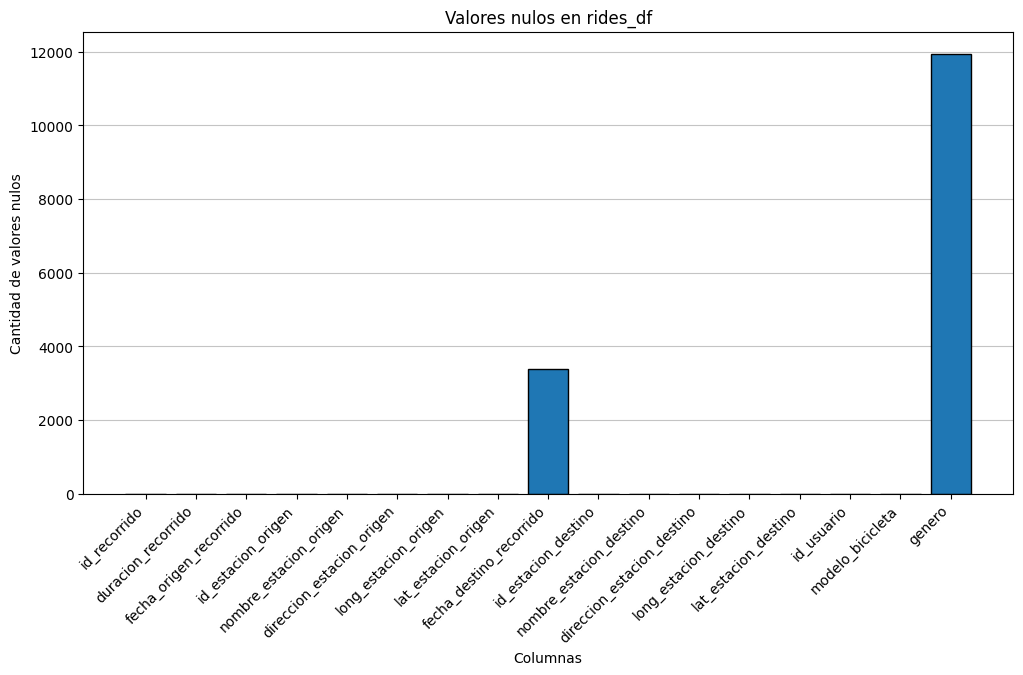

In [32]:
# Exploración de valores nulos
plt.figure(figsize=(12, 6))
plt.grid(axis='y', alpha=0.75)
plt.bar(rides_df.columns, rides_df.isnull().sum(), align='center', zorder=2, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en rides_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

##### Exploración de duraciones de recorrido

In [33]:
rides_df['duracion_recorrido_min'] = rides_df['duracion_recorrido'] / 60

In [34]:
# Recorrido mas largo en días
print(f"Recorrido más largo: {round(rides_df['duracion_recorrido'].max()/3600/24, 2)} días")

Recorrido más largo: 29.76 días


In [35]:
# Recorrido mas corto en minutos
print(f"Recorrido más corto: {round(rides_df['duracion_recorrido_min'].min(), 2)} minutos")

# Recorrido mas largo en minutos
print(f"Recorrido más largo: {round(rides_df['duracion_recorrido_min'].max(), 2)} minutos")

Recorrido más corto: 0.0 minutos
Recorrido más largo: 42852.75 minutos


In [36]:
# El usuario que más tiempo usó las bicicletas
user_durations = rides_df.groupby('id_usuario')['duracion_recorrido'].sum()
max_user_id = user_durations.idxmax()
max_user_duration = user_durations.max()

print(f"Usuario más activo: {max_user_duration/3600:.2f} hs")

Usuario más activo: 738.33 hs


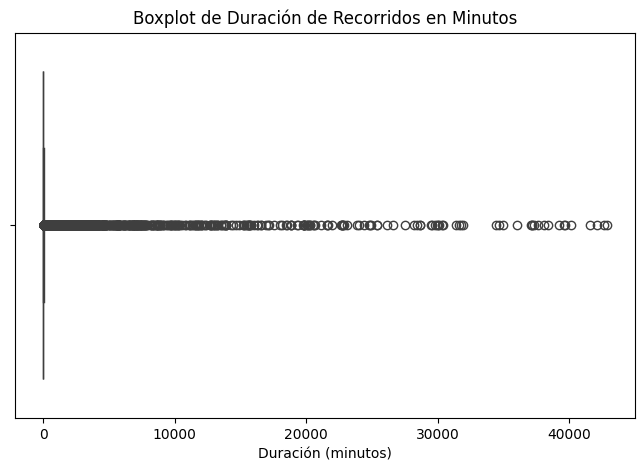

In [37]:
# Boxplot de duracion de recorridos en minutos
plt.figure(figsize=(8, 5))
sns.boxplot(x=rides_df['duracion_recorrido_min'])
plt.title('Boxplot de Duración de Recorridos en Minutos')
plt.xlabel('Duración (minutos)')
plt.show()

In [38]:
# Cuartiles en minutos
Q1 = rides_df['duracion_recorrido_min'].quantile(0.25)
Q2 = rides_df['duracion_recorrido_min'].quantile(0.50)
Q3 = rides_df['duracion_recorrido_min'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 (25%):", Q1)
print("Q2 (Mediana, 50%):", Q2)
print("Q3 (75%):", Q3)
print("IQR (Rango Intercuartílico):", IQR)

Q1 (25%): 8.216666666666667
Q2 (Mediana, 50%): 14.683333333333334
Q3 (75%): 24.55
IQR (Rango Intercuartílico): 16.333333333333336


In [39]:
# Media moda mediana de duraciones (en minutos)
mean = rides_df['duracion_recorrido_min'].mean().round(2)
median = rides_df['duracion_recorrido_min'].median().round(2)
mode = rides_df['duracion_recorrido_min'].mode()[0].round(2)
var = rides_df['duracion_recorrido_min'].var().round(2)
std_dev = rides_df['duracion_recorrido_min'].std().round(2)

print(f"Media: {mean} min")
print(f"Mediana: {median} min")
print(f"Moda: {mode} min")
print(f"Varianza: {var} min²")
print(f"Desviación estándar: {std_dev} min")

Media: 21.24 min
Mediana: 14.68 min
Moda: 0.03 min
Varianza: 25507.91 min²
Desviación estándar: 159.71 min


In [40]:
print(f"Asímetría de duracion: {rides_df['duracion_recorrido_min'].skew():.2f}")
print(f"Curtosis de duracion: {rides_df['duracion_recorrido_min'].kurtosis():.2f}")

Asímetría de duracion: 156.24
Curtosis de duracion: 30117.53


La duración de recorridos es altamente asimétrica:
- Tiene muchos valores bajos
- Tiene pocos valores extremadamente altos (estiran la cola a derecha)

La duración de recorridos tiene una curtosis muy alta:
- Tiene una distribución 'picuda'
- Tiene una cola bien pesada

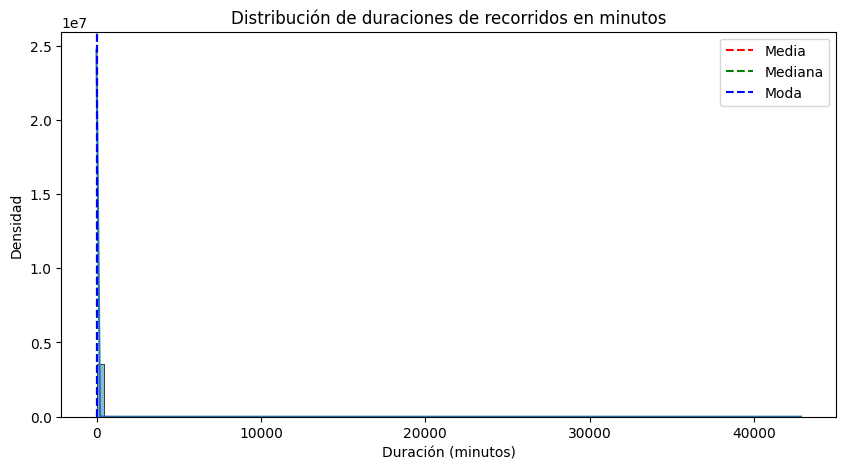

In [41]:
# Histograma de duraciones de recorridos en minutos
plt.figure(figsize=(10, 5))
ax =sns.histplot(rides_df['duracion_recorrido_min'], bins=100, kde=True)
plt.title('Distribución de duraciones de recorridos en minutos')
plt.xlabel('Duración (minutos)')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()

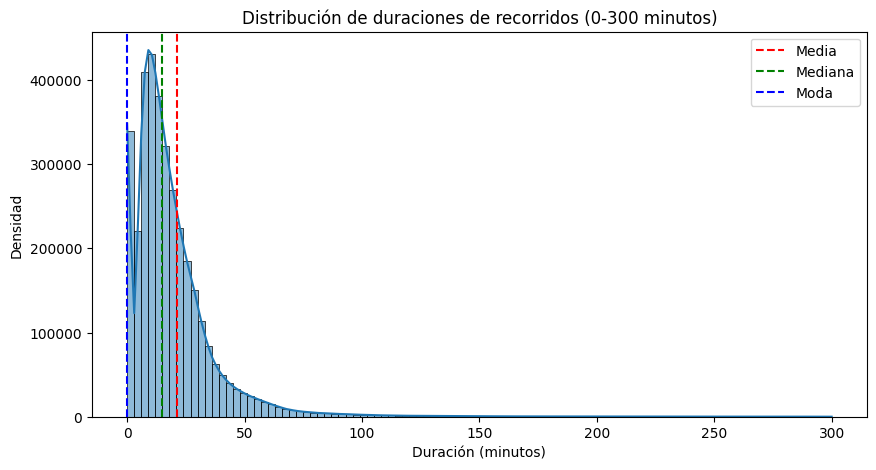

In [42]:
# Histograma de duraciones de recorridos en minutos (>0 y < 300)
mask_duration = (rides_df['duracion_recorrido_min'] > 0) & (rides_df['duracion_recorrido_min'] < 300)
plt.figure(figsize=(10, 5))
ax = sns.histplot(rides_df[mask_duration]['duracion_recorrido_min'], bins=100, kde=True)
plt.title('Distribución de duraciones de recorridos (0-300 minutos)')
plt.xlabel('Duración (minutos)')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()

##### Exploración de fecha origen de recorrido

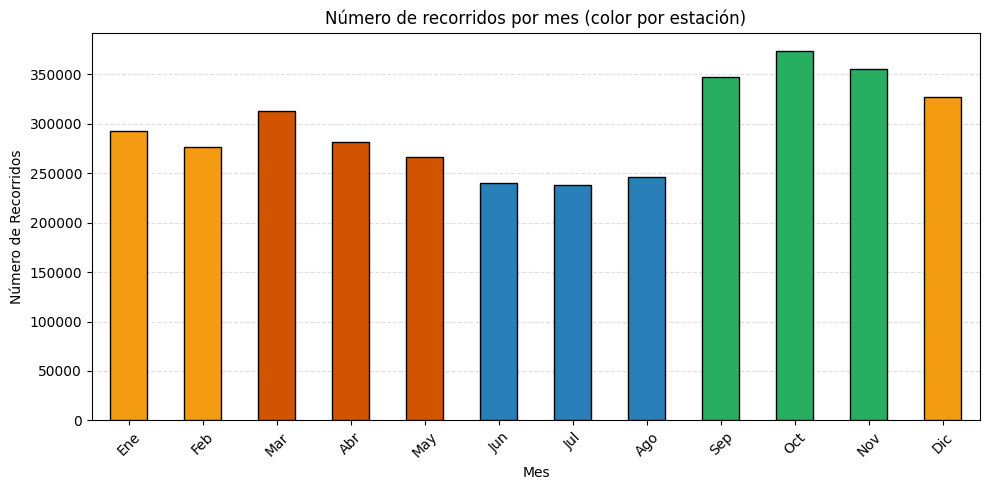

In [43]:
rides_df['fecha_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'])
rides_df['mes'] = rides_df['fecha_origen_recorrido'].dt.month

counts = rides_df['mes'].value_counts().reindex(range(1,13), fill_value=0).sort_index()

# Verano: Dic-Ene-Feb; Otoño: Mar-Abr-May; Invierno: Jun-Jul-Ago; Primavera: Sep-Oct-Nov
season_of = {12:'verano', 1:'verano', 2:'verano',
             3:'otoño', 4:'otoño', 5:'otoño',
             6:'invierno', 7:'invierno', 8:'invierno',
             9:'primavera', 10:'primavera', 11:'primavera'}
palette = {'verano':'#F39C12', 'otoño':'#D35400', 'invierno':'#2980B9', 'primavera':'#27AE60'}
colors = [palette[season_of[m]] for m in counts.index]

fig, ax = plt.subplots(figsize=(10, 5))
counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black', zorder=3)

ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)

ax.set_title('Número de recorridos por mes (color por estación)')
ax.set_xlabel('Mes'); ax.set_ylabel('Número de Recorridos')
ax.set_xticks(range(12))
ax.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'], rotation=45)

plt.tight_layout()
plt.show()


In [44]:
# Dia de la semana con más recorridos
rides_df['dia_semana_origen_recorrido'] = rides_df['fecha_origen_recorrido'].dt.day_name()
print(f"Día de la semana con más recorridos: {rides_df['dia_semana_origen_recorrido'].value_counts().idxmax()} con {rides_df['dia_semana_origen_recorrido'].value_counts().max()} recorridos")

Día de la semana con más recorridos: Thursday con 641452 recorridos


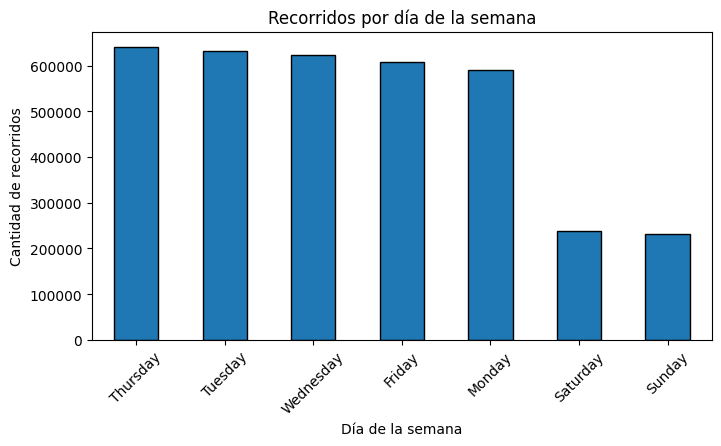

In [45]:
# Bar chart de recorridos por dia de la semana
plt.figure(figsize=(8, 4))
rides_df['dia_semana_origen_recorrido'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

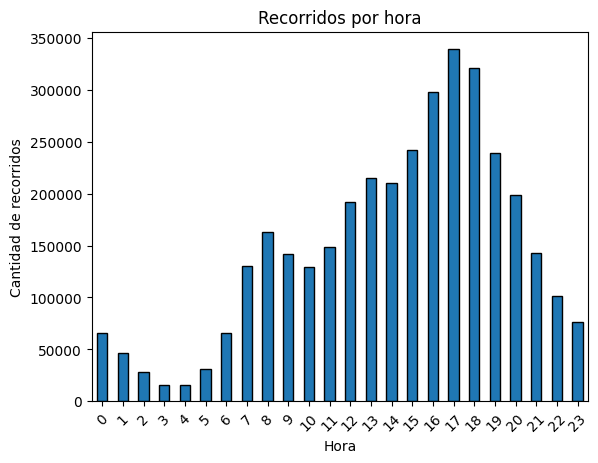

In [46]:
# Recorridos por hora
rides_df['hora_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'], format='%H:%M:%S', errors='coerce').dt.hour
rides_df['hora_origen_recorrido'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

##### Exploración de estaciones

In [47]:
# Estaciones más usadas para iniciar recorridos
origin_top_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=False).head(5)
print(origin_top_stations)

nombre_estacion_origen
147 - Constitución           38284
014 - Pacifico               37594
368 - PLAZA DE LA SHOÁ       37201
005 - Plaza Italia           34547
001 - FACULTAD DE DERECHO    30955
Name: count, dtype: int64


In [48]:
# Estaciones más usadas para terminar recorridos
destination_top_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=False).head(5)
print(destination_top_stations)

nombre_estacion_destino
147 - Constitución           38363
368 - PLAZA DE LA SHOÁ       37425
014 - Pacifico               37278
005 - Plaza Italia           34607
001 - FACULTAD DE DERECHO    30897
Name: count, dtype: int64


In [49]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Origenes
cols_ori = ['nombre_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']
coords = (rides_df[rides_df['nombre_estacion_origen'].isin(origin_top_stations.index)]
          [cols_ori].dropna().drop_duplicates('nombre_estacion_origen'))

for _, r in coords.iterrows():
    nombre, lat, lon = r['nombre_estacion_origen'], float(r['lat_estacion_origen']), float(r['long_estacion_origen'])
    
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='green', icon='play', prefix='fa')).add_to(m)
    
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_orig.html')

In [50]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Destinos
cols_dest = ['nombre_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']
coords_dest = (rides_df[rides_df['nombre_estacion_destino'].isin(destination_top_stations.index)]
               [cols_dest].dropna().drop_duplicates('nombre_estacion_destino'))

for _, r in coords_dest.iterrows():
    nombre, lat, lon = r['nombre_estacion_destino'], float(r['lat_estacion_destino']), float(r['long_estacion_destino'])
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='red', icon='flag-checkered', prefix='fa')).add_to(m)
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_dest.html')

In [51]:
# Estaciones menos usadas para iniciar recorridos
origin_bottom_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=True).head(5)
print(origin_bottom_stations)

nombre_estacion_origen
040 - HERRERA    258
125 - BILBAO     268
327 - IBERA      331
321 - EZEIZA     360
326 - PICO       385
Name: count, dtype: int64


In [52]:
# Estaciones menos usadas para terminar recorridos
destination_bottom_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=True).head(5)
print(destination_bottom_stations)

nombre_estacion_destino
-- CDO Chacarita -- (Temporal)      2
363 - Udaondo                       9
291 - REPARACION DE K7             11
125 - BILBAO                      272
040 - HERRERA                     283
Name: count, dtype: int64


##### Exploración de usuarios de recorridos

In [53]:
rides_df['id_usuario'] = rides_df['id_usuario'].astype('Int64')

In [54]:
# Usuario que más recorridos hizo
top_user = rides_df['id_usuario'].value_counts().idxmax()
print(f"Usuario que más recorridos hizo: ID {top_user} con {rides_df['id_usuario'].value_counts().max()} recorridos")

Usuario que más recorridos hizo: ID 844251 con 8488 recorridos


##### Exploración de modelo de bicicleta
No aporta información significativa

In [55]:
rides_df['modelo_bicicleta'].value_counts()

modelo_bicicleta
FIT       2583213
ICONIC     977191
Name: count, dtype: int64

##### Exploración de géneros (en recorridos, algunos no tienen género asociado)

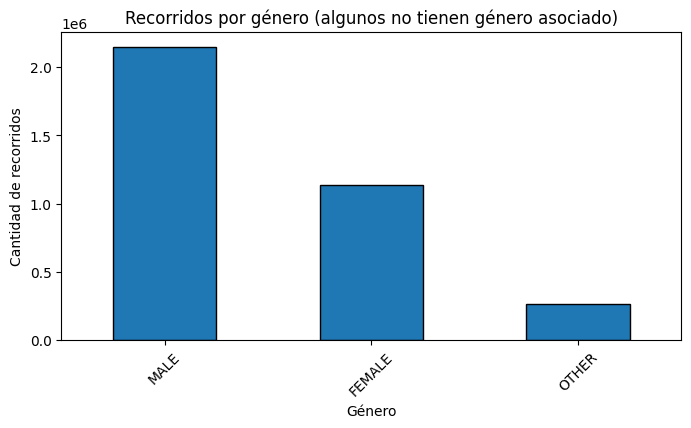

In [56]:
# Bar chart de recorridos por genero
plt.figure(figsize=(8, 4))
rides_df['genero'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por género (algunos no tienen género asociado)')
plt.xlabel('Género')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

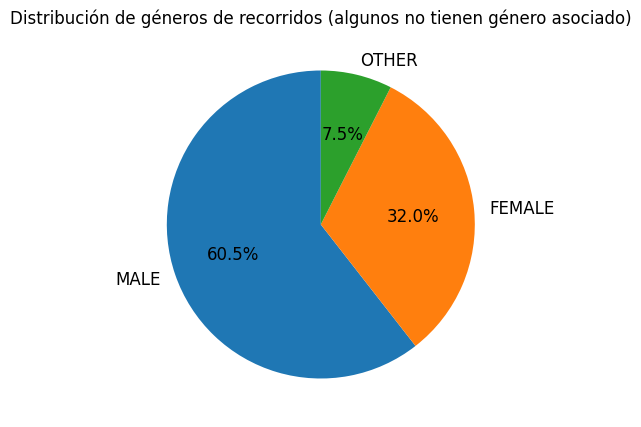

In [57]:
# Pie chart de generos de los recorridos (algunos recorridos no tienen género asociado)
plt.figure(figsize=(5, 5))
rides_df['genero'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de recorridos (algunos no tienen género asociado)')
plt.ylabel('')
plt.show()

### Merge datasets usuarios + recorridos?

In [58]:
# Cuántos usuarios de rides_df están en users_df?
np.isin(rides_df['id_usuario'], users_df['id_usuario']).sum()

np.int64(1136610)

No resulta útil unir ambos datasets, ya que más de un millón de recorridos no tienen `id_usuario` asociado.<br>
Esto se debe a que el dataset de usuarios 2024 solo incluye altas realizadas en ese año, mientras que el dataset de recorridos 2024 también contiene viajes de usuarios que se registraron en años anteriores.<br>
<br>
**Por eso se van a tratar ambos datasets de forma separada.**

# Split de los datasets

### Estrategia de partición para el dataset de recorridos

Se realiza un **split aleatorio** en lugar de un split temporal, por las siguientes razones:
- Datos únicamente de 2024 (un solo año)
- Existe fuerte estacionalidad intra-anual (más viajes en primavera/verano, menos en invierno)
- No se cuenta con datos históricos de años anteriores o posteriores

**Justificación del split aleatorio:**
1. **Evita sesgo estacional**: Un split temporal (por ej.: 80% primeros meses → 20% últimos meses) haría que train y test tengan distribuciones estacionales diferentes, sesgando la evaluación.

2. **Representatividad**: El shuffle garantiza que tanto train como test contengan datos de todas las estaciones del año, manteniendo la distribución temporal.

3. **No hay generalización temporal**: Como solo tenemos un año, no podemos evaluar predicción hacia el futuro (2025 en adelante). El objetivo en este dataset es evaluar la capacidad de generalización del modelo sobre patrones intra-anuales, no sobre datos futuros desconocidos.

<br>

**Nota: Si en el futuro se incorporan datos de múltiples años, sería apropiado usar un split temporal (entrenar con años 2022-2023, testear con 2024) para evaluar capacidad predictiva sobre el futuro, y evitando data leakage.**

In [59]:
TEST_PROPORTION = 0.2  # 20% para test
RANDOM_SEED = 25

In [60]:
users_df_train, users_df_test = train_test_split(users_df,
                                                 test_size=TEST_PROPORTION,
                                                 shuffle=True,
                                                 random_state=RANDOM_SEED)

In [61]:
rides_df_train, rides_df_test = train_test_split(rides_df,
                                                 test_size=TEST_PROPORTION,
                                                 random_state=RANDOM_SEED)

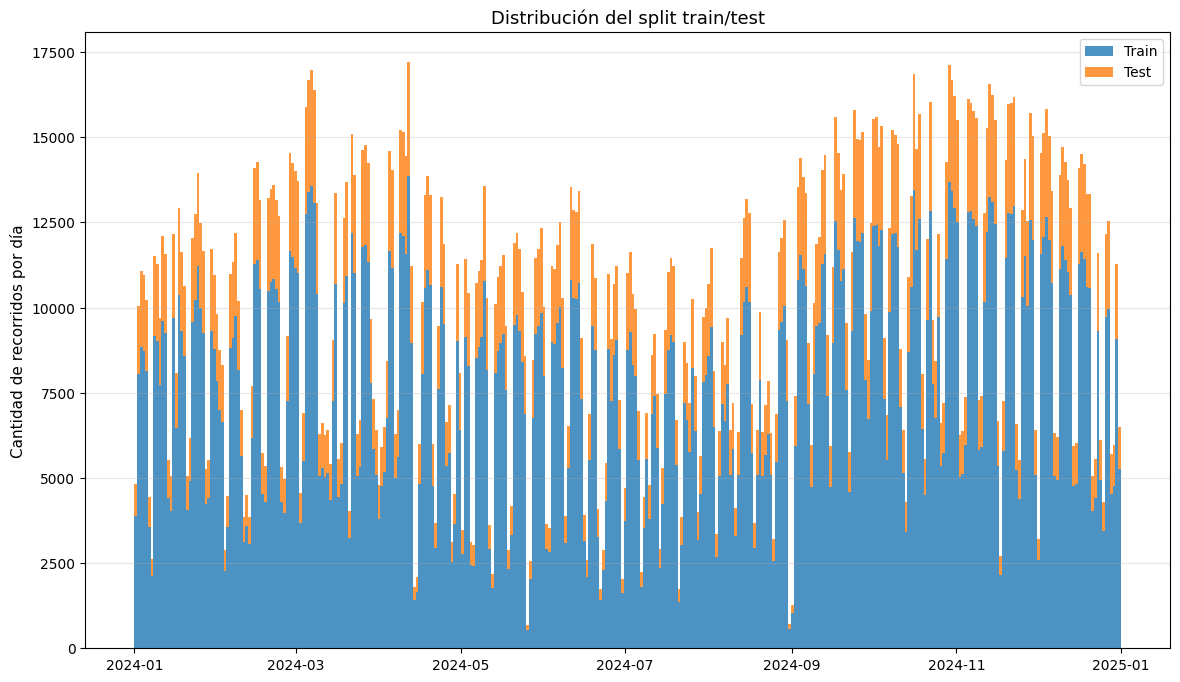

In [62]:
# Verificación del split
fig, ax = plt.subplots(figsize=(14, 8))

ax.hist([rides_df_train['fecha_origen_recorrido'], rides_df_test['fecha_origen_recorrido']], 
         bins=365,  # Un bin por día
         stacked=True,
         label=['Train', 'Test'],
         color=['#1f77b4', '#ff7f0e'],
         alpha=0.8,
         edgecolor='none')

ax.set_ylabel('Cantidad de recorridos por día', fontsize=11)
ax.set_title('Distribución del split train/test', 
              fontsize=13)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.show()

# Análisis y tratamiento de faltantes

### Usuarios

In [63]:
users_df_train.isna().sum()

id_usuario        0
genero_usuario    0
edad_usuario      0
fecha_alta        0
hora_alta         0
fecha_alta_dt     0
hora_alta_dt      0
dia_semana        0
dtype: int64

In [64]:
users_df_train.dia_semana.unique()  # Check que los días sean datos válidos

array(['Saturday', 'Tuesday', 'Wednesday', 'Friday', 'Sunday', 'Monday',
       'Thursday'], dtype=object)

In [65]:
users_df_train.genero_usuario.unique()  # Check que los géneros sean datos válidos

array(['FEMALE', 'MALE', 'OTHER'], dtype=object)

In [66]:
users_df_train['fecha_alta_dt'].dt.year.unique()  # Check que los años sean datos válidos

array([2024], dtype=int32)

**No hay datos faltantes en el dataset de usuarios**

### Recorridos

In [67]:
rides_df_train.isna().sum()

id_recorrido                      0
duracion_recorrido                0
fecha_origen_recorrido            0
id_estacion_origen                0
nombre_estacion_origen            0
direccion_estacion_origen         0
long_estacion_origen              0
lat_estacion_origen               0
fecha_destino_recorrido        2700
id_estacion_destino               0
nombre_estacion_destino           0
direccion_estacion_destino        0
long_estacion_destino             0
lat_estacion_destino              0
id_usuario                        0
modelo_bicicleta                  0
genero                         9543
duracion_recorrido_min            0
mes                               0
dia_semana_origen_recorrido       0
hora_origen_recorrido             0
dtype: int64

In [68]:
mask_duration_zero = rides_df_train["duracion_recorrido"] == 0
print(f"Recorridos con duración 0: {mask_duration_zero.sum()}")

mask_origin_neq_destination = rides_df_train["id_estacion_origen"] != rides_df_train["id_estacion_destino"]
mask_origin_eq_destination = rides_df_train["id_estacion_origen"] == rides_df_train["id_estacion_destino"]

mask_duration_zero_and_origin_neq_destination = mask_duration_zero & mask_origin_neq_destination
mask_duration_zero_and_origin_eq_destination = mask_duration_zero & mask_origin_eq_destination

print(f"Recorridos con duración 0 y origen distinto a destino: {mask_duration_zero_and_origin_neq_destination.sum()}")
print(f"Recorridos con duración 0 y origen igual a destino: {mask_duration_zero_and_origin_eq_destination.sum()}")

mask_duration_zero_and_origin_eq_destination_and_same_date = mask_duration_zero_and_origin_eq_destination & (rides_df_train["fecha_origen_recorrido"] == rides_df_train["fecha_destino_recorrido"])
mask_duration_zero_and_origin_eq_destination_and_different_date = mask_duration_zero_and_origin_eq_destination & (rides_df_train["fecha_origen_recorrido"] != rides_df_train["fecha_destino_recorrido"])
print(f"Recorridos con duración 0, origen igual a destino y misma fecha de origen y destino: {mask_duration_zero_and_origin_eq_destination_and_same_date.sum()}")
print(f"Recorridos con duración 0, origen igual a destino y distinta fecha de origen y destino: {mask_duration_zero_and_origin_eq_destination_and_different_date.sum()}")

Recorridos con duración 0: 30149
Recorridos con duración 0 y origen distinto a destino: 25156
Recorridos con duración 0 y origen igual a destino: 4993
Recorridos con duración 0, origen igual a destino y misma fecha de origen y destino: 4928
Recorridos con duración 0, origen igual a destino y distinta fecha de origen y destino: 65


**Podemos considerar que los siguientes registros de duración de recorridos son faltantes:**
- **Duración 0 y origen distinto a destino**: la bicicleta se movió de estación, el tiempo de viaje no puede ser 0
- **Duración 0 y origen igual a destino, pero distinta fecha de origen que destino**: la bicicleta viajó y volvió a la misma estación, el tiempo de viaje no puede ser 0

In [69]:
rides_df_train[mask_duration_zero_and_origin_neq_destination]["mes"].value_counts().sort_index()

mes
1     1157
2     2230
3     2436
4     2036
5     1788
6     1475
7     1285
8     1609
9     2283
10    2114
11    2918
12    3825
Name: count, dtype: int64

In [70]:
print(f"Proporción de recorridos con duración 0 y origen distinto a destino: {mask_duration_zero_and_origin_neq_destination.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con duración 0 y origen distinto a destino: 0.883 %


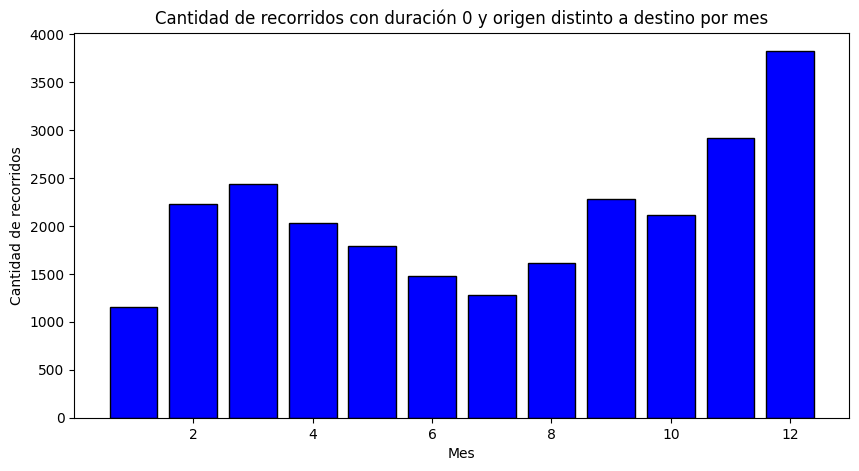

In [71]:
# Bar chart de cantidad de recorridos con duración 0 y origen distinto a destino por mes
plt.figure(figsize=(10, 5))
month_counts = rides_df_train[mask_duration_zero_and_origin_neq_destination]['mes'].value_counts().sort_index()
plt.bar(month_counts.index, month_counts.values, color='blue', edgecolor='black')
plt.title('Cantidad de recorridos con duración 0 y origen distinto a destino por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de recorridos')
plt.show()

**Los recorridos con duración 0 y origen distinto a destino, no se distribuyen con un patrón específico sino que siguen el comportamiento del número de recorridos totales por mes, con lo cual parece que estos registros faltan de forma completamente aleatoria (MCAR).**

In [72]:
rides_df_train[mask_duration_zero_and_origin_eq_destination_and_different_date]["mes"].value_counts().sort_index()

mes
11    25
12    40
Name: count, dtype: int64

In [73]:
print(f"Proporción de recorridos con duración 0 y origen igual a destino y distinta fecha de origen que destino: {mask_duration_zero_and_origin_eq_destination_and_different_date.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con duración 0 y origen igual a destino y distinta fecha de origen que destino: 0.002 %


**Los recorridos con duración 0, origen igual a destino pero distinta fecha de origen que destino no se distribuyen de forma random, sino que solo se dan en noviembre y diciembre, probablemente estén relacionados con los faltantes que están más adelante en este análisis.**

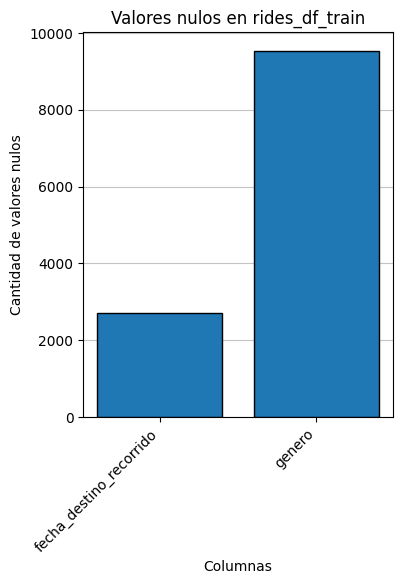

In [74]:
cols = ["fecha_destino_recorrido", "genero"]

plt.figure(figsize=(4, 5))
plt.grid(axis='y', alpha=0.75)
plt.bar(cols, rides_df_train[cols].isnull().sum(), align='center', zorder=2, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en rides_df_train')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

##### Faltantes de fecha_destino_recorrido

In [75]:
mask_date_na = rides_df_train["fecha_destino_recorrido"].isna()
rides_df_train[mask_date_na].head(5)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,duracion_recorrido_min,mes,dia_semana_origen_recorrido,hora_origen_recorrido
923079,24181455,0,2024-12-05 17:55:10,449,352 - San Jose de Flores,Av. Rivadavia 6955,-58.463297,-34.628836,NaN,509,386 - VELEZ SARSFIELD,Av. Carrasco 214,-58.489810,-34.633638,67340,ICONIC,MALE,0.0,12,Thursday,17
452438,24362617,0,2024-12-18 21:13:51,183,183 - VIRREY CEVALLOS,Mexico 1652,-58.389973,-34.615699,NaN,474,224 - BAIGORRIA,Baigorria 4101,-58.503020,-34.610892,709592,ICONIC,MALE,0.0,12,Wednesday,21
1073307,24231281,0,2024-12-09 20:31:15,61,098 - BENITO JUAREZ,Benito Juarez 2231,-58.505177,-34.618927,NaN,197,197 - PLAZA CIUDAD DE UDINE,Mercedes 1480,-58.493044,-34.620998,1197740,FIT,FEMALE,0.0,12,Monday,20
1708802,24002555,0,2024-11-22 21:16:05,118,118 - MEXICO,Saavedra & Mexico,-58.402653,-34.617020,NaN,183,183 - VIRREY CEVALLOS,Mexico 1652,-58.389973,-34.615699,1049513,FIT,MALE,0.0,11,Friday,21
722927,24282718,0,2024-12-12 22:20:04,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,NaN,449,352 - San Jose de Flores,Av. Rivadavia 6955,-58.463297,-34.628836,751098,FIT,MALE,0.0,12,Thursday,22


In [76]:
rides_df_train[mask_date_na]["mes"].value_counts().sort_index()

mes
11     911
12    1789
Name: count, dtype: int64

**Indicios de que el sistema funcionó mal en algunos dias de noviembre y diciembre.**

In [77]:
print(f"Proporción de recorridos con fecha destino nula: {mask_date_na.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con fecha destino nula: 0.095 %


In [78]:
mask_nov = rides_df_train["mes"] == 11
mask_dec = rides_df_train["mes"] == 12
mask_nov_dec = mask_nov | mask_dec
mask_nov_na = mask_nov & mask_date_na
mask_dec_na = mask_dec & mask_date_na

In [79]:
rides_df_train[mask_nov_na]

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,duracion_recorrido_min,mes,dia_semana_origen_recorrido,hora_origen_recorrido
1708802,24002555,0,2024-11-22 21:16:05,118,118 - MEXICO,Saavedra & Mexico,-58.402653,-34.617020,NaN,183,183 - VIRREY CEVALLOS,Mexico 1652,-58.389973,-34.615699,1049513,FIT,MALE,0.0,11,Friday,21
1790058,24002606,0,2024-11-22 21:20:10,208,145 - RAVIGNANI,EMILIO RAVIGNANI 1802,-58.438404,-34.580716,NaN,99,099 - Malabia,780 Malabia & Loyola,-58.435408,-34.596096,1224704,FIT,MALE,0.0,11,Friday,21
1827770,24031179,0,2024-11-25 19:43:09,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,NaN,281,350 - Plaza Irlanda,Av. Gaona 2200,-58.458315,-34.613778,1162255,FIT,FEMALE,0.0,11,Monday,19
1659379,24050491,0,2024-11-26 21:53:56,65,065 - Julián Álvarez,3822 Guemes,-58.415787,-34.587312,NaN,242,103 - MALBA,Av. Pres. Figueroa Alcorta 3451,-58.403984,-34.576949,998977,ICONIC,FEMALE,0.0,11,Tuesday,21
2807471,23779551,0,2024-11-07 20:26:25,329,100 - Plaza Gurruchaga,Gurruchaga 1084,-58.435066,-34.593110,NaN,291,244 - UADE,Lima 750,-58.381627,-34.617247,1021892,FIT,MALE,0.0,11,Thursday,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457363,24102163,0,2024-11-29 22:16:15,163,163 - ONCE II,Bartolome Mitre & Av. Puyrredon,-58.406431,-34.609566,NaN,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,816666,FIT,OTHER,0.0,11,Friday,22
1805173,24049208,0,2024-11-26 20:19:34,476,279 - PLAZA MONTE CASTRO,Gualeguaychú 1900,-58.498525,-34.618292,NaN,455,039 - Plaza Don Bosco,Elpidio Gonzalez 5181,-58.508050,-34.626520,596530,FIT,OTHER,0.0,11,Tuesday,20
1818433,24010944,0,2024-11-23 23:40:26,543,139 - CASA ROSADA,Av. Alicia Moreau de Justo 861,-58.366741,-34.607480,NaN,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,1113786,FIT,FEMALE,0.0,11,Saturday,23
1553177,24101483,0,2024-11-29 21:11:11,9,009 - Parque Las Heras,"2300 Diaz, Cnel. Av. & French",-58.407741,-34.585443,NaN,50,050 - Hospital Rivadavia,2516 Pereyra Lucena,-58.401080,-34.583735,1162316,FIT,MALE,0.0,11,Friday,21


In [80]:
mask_duration_zero_and_nov_na = mask_nov_na & mask_duration_zero
print(f"Recorridos en noviembre con duración 0 y fecha destino nula: {mask_duration_zero_and_nov_na.sum()}")

mask_duration_zero_and_dec_na = mask_dec_na & mask_duration_zero
print(f"Recorridos en diciembre con duración 0 y fecha destino nula: {mask_duration_zero_and_dec_na.sum()}")

Recorridos en noviembre con duración 0 y fecha destino nula: 911
Recorridos en diciembre con duración 0 y fecha destino nula: 1789


**Se observa que todos los registros faltantes de `fecha_destino_recorrido` también tienen duración 0**

In [81]:
pd.to_datetime(rides_df_train["fecha_origen_recorrido"], errors='coerce').dt.year.unique()  # Check que los años sean datos válidos

array([2024], dtype=int32)

In [82]:
pd.to_datetime(rides_df_train['fecha_destino_recorrido'], errors='coerce').dt.year.unique()  # Check que los años sean datos válidos

array([2024.,   nan, 2025.])

##### Faltantes de genero

In [83]:
mask_gen_na = rides_df_train["genero"].isna()
print(f"Recorridos con género faltante: {mask_gen_na.sum()}")

Recorridos con género faltante: 9543


In [84]:
print(f"Proporción de recorridos con género faltante: {mask_gen_na.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con género faltante: 0.335 %


In [85]:
rides_df_train[mask_gen_na]["mes"].value_counts().sort_index()

mes
1     778
2     671
3     853
4     756
5     861
6     723
7     720
8     765
9     871
10    912
11    830
12    803
Name: count, dtype: int64

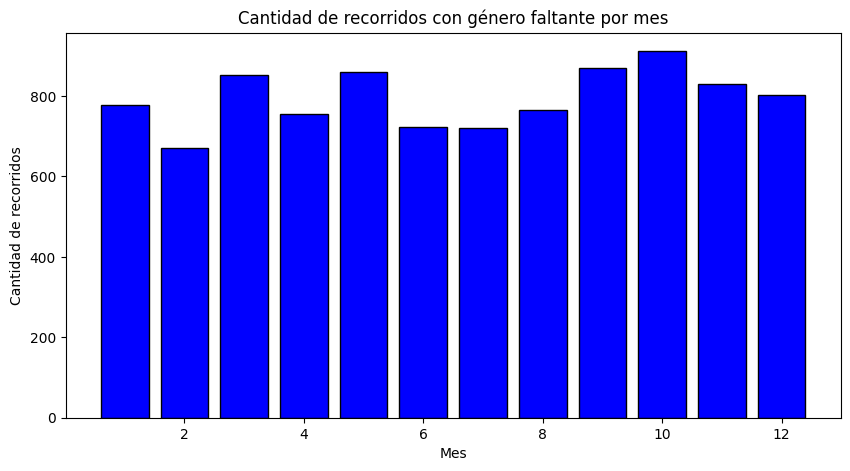

In [86]:
# Bar chart de cantidad de recorridos con género faltante por mes
plt.figure(figsize=(10, 5))
month_counts = rides_df_train[mask_gen_na]['mes'].value_counts().sort_index()
plt.bar(month_counts.index, month_counts.values, color='blue', edgecolor='black')
plt.title('Cantidad de recorridos con género faltante por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de recorridos')
plt.show()

**Los recorridos con género faltante, no se distribuyen con un patrón específico sino que siguen el comportamiento del número de recorridos totales por mes, con lo cual parece que estos registros faltan de forma completamente aleatoria (MCAR).**

### Estrategias para tratamiento de faltantes
- Recorridos con duración 0 y origen distinto a destino faltan de forma completamente aleatoria (MCAR) y representan un 0.88 % de los registros de training -> **Aplicamos eliminación de fila**
<br>
<br>
- Recorridos con duración 0 y origen igual a destino y distinta fecha de origen que destino no son MCAR, pero igualmente representan un 0.002 % -> **Aplicamos eliminación de fila**
<br>
<br>
- Recorridos con fecha destino nula no son MCAR, pero igualmente representan un 0.095 % de los registros de training -> **Aplicamos eliminación de fila**
<br>
<br>
- Recorridos sin género faltan de forma completamente aleatoria (MCAR) y representan un 0.335 % de los registros de training -> **Aplicamos eliminación de fila**

In [87]:
# No se eliminan datos en users_df_train
users_df_train_cleaned = users_df_train.copy()

In [88]:
mask_for_deletion = mask_duration_zero_and_origin_neq_destination | mask_duration_zero_and_origin_eq_destination_and_different_date | mask_date_na | mask_gen_na
print(f"Total de recorridos a eliminar: {mask_for_deletion.sum()} ({mask_for_deletion.sum() / len(rides_df_train) * 100:.3f} % del total)")
rides_df_train_cleaned = rides_df_train[~mask_for_deletion].copy()
rides_df_train_cleaned.reset_index(drop=True, inplace=True)

Total de recorridos a eliminar: 34680 (1.218 % del total)


# Análisis y tratamiento de outliers

### Usuarios

Se vio Más arriba en la etapa exploratoria que `edad_usuario` contiene muchos valores atípicos, incluso algunos por encima de los 1000 años.<br>
Probablemente se debió a un error al ingresar el dato en el sistema, al momento del alta de usuario.<br>
Los términos y condiciones del sistema contemplan usuarios con edad mínima 16 años.

In [89]:
# Edades < 16
mask_age_lt_16 = users_df_train_cleaned["edad_usuario"] < 16
print(f"Usuarios con edad < 16: {mask_age_lt_16.sum()} ({mask_age_lt_16.sum() / len(users_df_train_cleaned) * 100:.3f} % del total)")
users_df_train_cleaned[mask_age_lt_16]

Usuarios con edad < 16: 8 (0.005 % del total)


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta,fecha_alta_dt,hora_alta_dt,dia_semana
157229,1087178,MALE,15,2024-01-05,23:09:04,2024-01-05,23:09:04,Friday
132348,1257721,OTHER,5,2024-11-24,14:02:31,2024-11-24,14:02:31,Sunday
116314,1225229,MALE,5,2024-10-09,11:42:12,2024-10-09,11:42:12,Wednesday
94405,1083783,MALE,4,2024-01-01,12:05:43,2024-01-01,12:05:43,Monday
73194,1138759,MALE,5,2024-04-02,08:47:40,2024-04-02,08:47:40,Tuesday
124842,1192893,MALE,15,2024-08-16,00:07:41,2024-08-16,00:07:41,Friday
44659,1200706,MALE,4,2024-09-04,19:32:10,2024-09-04,19:32:10,Wednesday
49179,1216711,OTHER,5,2024-09-28,10:55:52,2024-09-28,10:55:52,Saturday


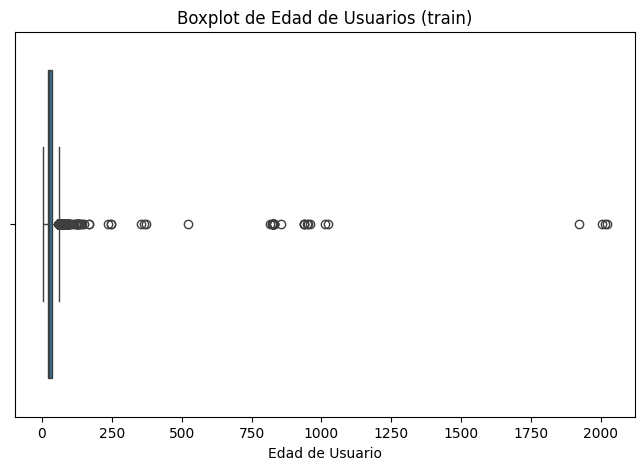

Outliers en edad_usuario: 2663 (1.689 % del total)
Valores de outliers: 2021 (máximo), 62 (mínimo)
Conteo de valores de outliers:
62: 368
63: 309
64: 249
65: 220
66: 184
67: 182
68: 153
71: 119
69: 111
72: 105
70: 98
73: 78
75: 66
74: 59
77: 50
76: 49
78: 40
79: 32
80: 29
83: 18
81: 18
82: 15
84: 10
86: 9
85: 9
88: 5
89: 5
90: 4
93: 4
87: 4
828: 4
91: 4
830: 3
938: 3
102: 2
124: 2
123: 2
92: 2
247: 2
129: 2
960: 1
827: 1
825: 1
2004: 1
236: 1
815: 1
139: 1
98: 1
2016: 1
829: 1
952: 1
353: 1
94: 1
138: 1
127: 1
373: 1
855: 1
824: 1
1012: 1
107: 1
170: 1
168: 1
149: 1
367: 1
113: 1
96: 1
948: 1
524: 1
142: 1
128: 1
2021: 1
826: 1
131: 1
1022: 1
1921: 1


In [90]:
# Detectar outliers en edad_usuario usando método de IQR
Q1 = users_df_train_cleaned['edad_usuario'].quantile(0.25)
Q3 = users_df_train_cleaned['edad_usuario'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (users_df_train_cleaned['edad_usuario'] < lower_bound) | (users_df_train_cleaned['edad_usuario'] > upper_bound)
outliers = users_df_train_cleaned[outliers_mask]

plt.figure(figsize=(8, 5))
sns.boxplot(x=users_df_train_cleaned['edad_usuario'])
plt.title('Boxplot de Edad de Usuarios (train)')
plt.xlabel('Edad de Usuario')
plt.show()

print(f"Outliers en edad_usuario: {outliers.shape[0]} ({outliers.shape[0] / users_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers: {outliers['edad_usuario'].max()} (máximo), {outliers['edad_usuario'].min()} (mínimo)")
print(f"Conteo de valores de outliers:")
for valor, cantidad in outliers['edad_usuario'].value_counts().items():
    print(f"{valor}: {cantidad}")

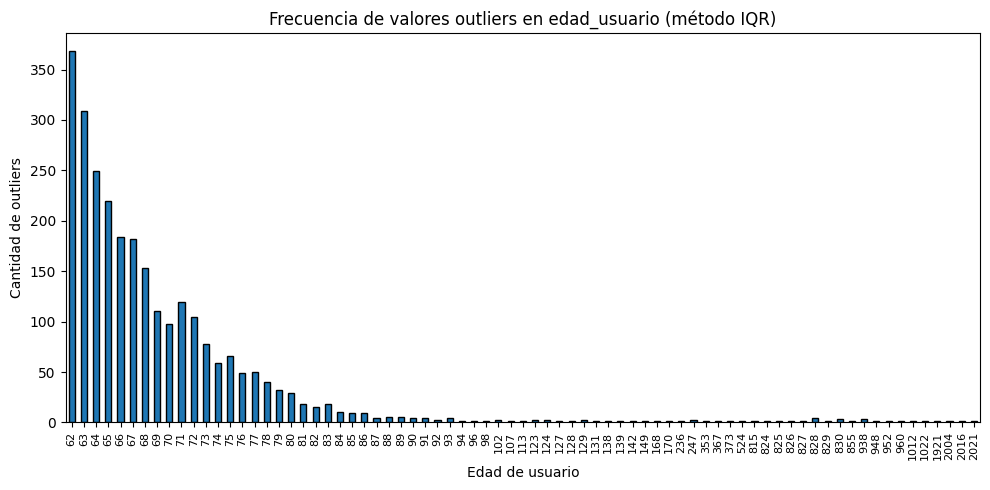

In [91]:
plt.figure(figsize=(10, 5))
outliers['edad_usuario'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Frecuencia de valores outliers en edad_usuario (método IQR)')
plt.xlabel('Edad de usuario')
plt.ylabel('Cantidad de outliers')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

El método de IQR parece tomar valores perfectamente posibles (62 a 98) como outliers.<br>
Esto se debe a que este método funciona mejor para distribuciones relativamente simétricas, y `edad_usuario` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [92]:
# Outliers en edad_usuario usando método de desvio estandar (Z-score)
z_scores = np.abs(stats.zscore(users_df_train_cleaned['edad_usuario']))
z_threshold = 3  # Umbral típico
outliers_z = users_df_train_cleaned[z_scores > z_threshold]
print(f"Outliers detectados en edad_usuario por Z-score: {outliers_z.shape[0]} ({outliers_z.shape[0] / users_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers por Z-score: {outliers_z['edad_usuario'].max()} (máximo), {outliers_z['edad_usuario'].min()} (mínimo)")
outliers_z['edad_usuario'].value_counts().sort_index()

Outliers detectados en edad_usuario por Z-score: 92 (0.058 % del total)
Valores de outliers por Z-score: 2021 (máximo), 86 (mínimo)


edad_usuario
86      9
87      4
88      5
89      5
90      4
91      4
92      2
93      4
94      1
96      1
98      1
102     2
107     1
113     1
123     2
124     2
127     1
128     1
129     2
131     1
138     1
139     1
142     1
149     1
168     1
170     1
236     1
247     2
353     1
367     1
373     1
524     1
815     1
824     1
825     1
826     1
827     1
828     4
829     1
830     3
855     1
938     3
948     1
952     1
960     1
1012    1
1022    1
1921    1
2004    1
2016    1
2021    1
Name: count, dtype: int64

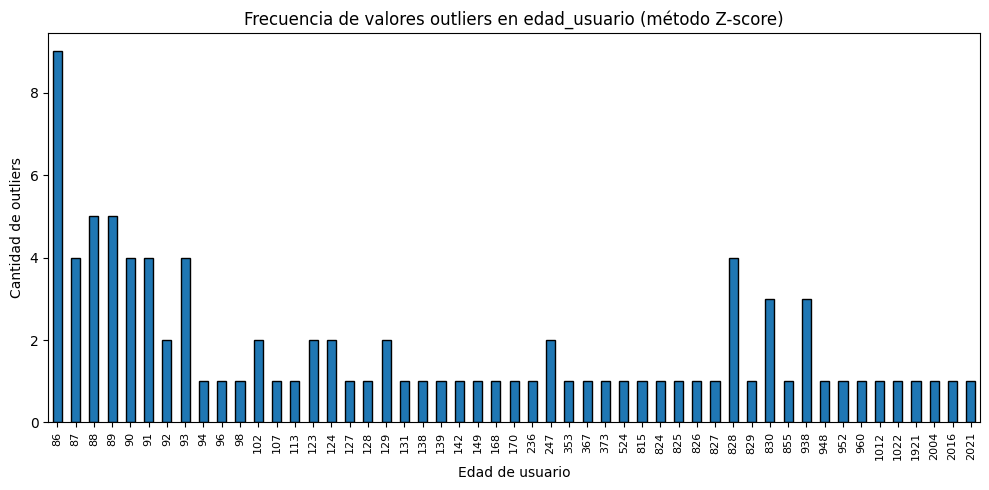

In [93]:
# Plot de outliers detectados por Z-score
plt.figure(figsize=(10, 5))
outliers_z['edad_usuario'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Frecuencia de valores outliers en edad_usuario (método Z-score)')
plt.xlabel('Edad de usuario')
plt.ylabel('Cantidad de outliers')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

El método de desvio estandar (Z-score) parece funcionar mejor que el método de IQR, pero igualmente funciona mejor para distribuciones relativamente simétricas, y `edad_usuario` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [94]:
# MATRIZ DE INTERSECCIONES Y ANÁLISIS DE CONSENSO - SOLO ENCODING SENO
print(f"\n{'='*80}")
print("MATRIZ DE INTERSECCIONES Y ANÁLISIS DE CONSENSO")
print(f"{'='*80}")

# Crear diccionario con técnicas de selección y sus features
tecnicas_seleccion_seno = ['Pearson', 'Varianza', 'ANOVA', 'Kendall']
tecnicas_features_seno = {
    'Pearson': features_pearson_seno,
    'Varianza': features_varianza_seno,
    'ANOVA': features_anova_seno,
    'Kendall': features_kendall_seno
}

# Crear sets para análisis de intersecciones
sets_seleccion_seno = [
    set(features_pearson_seno),
    set(features_varianza_seno), 
    set(features_anova_seno),
    set(features_kendall_seno)
]

# Crear matriz de intersecciones
n_tecnicas = len(tecnicas_seleccion_seno)
matriz_interseccion_seno = np.zeros((n_tecnicas, n_tecnicas))

for i in range(n_tecnicas):
    for j in range(n_tecnicas):
        interseccion = sets_seleccion_seno[i].intersection(sets_seleccion_seno[j])
        matriz_interseccion_seno[i, j] = len(interseccion)

print("Matriz de intersecciones creada:")
print(f"  Dimensiones: {matriz_interseccion_seno.shape}")

# Mostrar la matriz
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(matriz_interseccion_seno, cmap='Blues')

# Configurar etiquetas
ax.set_xticks(np.arange(n_tecnicas))
ax.set_yticks(np.arange(n_tecnicas))
ax.set_xticklabels(tecnicas_seleccion_seno)
ax.set_yticklabels(tecnicas_seleccion_seno)

# Agregar valores en cada celda
for i in range(n_tecnicas):
    for j in range(n_tecnicas):
        text = ax.text(j, i, int(matriz_interseccion_seno[i, j]),
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title("Matriz de Intersecciones - Solo Encoding Seno", 
             fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im)
plt.tight_layout()
plt.show()

Edades después de winsorización:
count    157,663.00
mean          30.59
std           11.66
min           16.00
25%           21.00
50%           27.00
75%           37.00
max          100.00
Name: edad_usuario_winsorized, dtype: object


In [95]:
# ANÁLISIS DETALLADO DE INTERSECCIONES - SOLO ENCODING SENO
print(f"\n{'='*80}")
print("ANÁLISIS DETALLADO DE INTERSECCIONES")
print(f"{'='*80}")

# Definir sets para facilitar el análisis
set_pearson_seno = set(features_pearson_seno)
set_varianza_seno = set(features_varianza_seno)
set_anova_seno = set(features_anova_seno)
set_kendall_seno = set(features_kendall_seno)

# Intersecciones por pares
intersecciones_seno = {
    'Pearson ∩ Varianza': set_pearson_seno & set_varianza_seno,
    'Pearson ∩ ANOVA': set_pearson_seno & set_anova_seno,
    'Pearson ∩ Kendall': set_pearson_seno & set_kendall_seno,
    'Varianza ∩ ANOVA': set_varianza_seno & set_anova_seno,
    'Varianza ∩ Kendall': set_varianza_seno & set_kendall_seno,
    'ANOVA ∩ Kendall': set_anova_seno & set_kendall_seno
}

print("Intersecciones por pares:")
for nombre, interseccion in intersecciones_seno.items():
    print(f"{nombre:<25}: {len(interseccion):>2} features")
    if interseccion:
        # Mostrar hasta 5 features y truncar si hay más
        features_mostrar = list(interseccion)[:5]
        features_str = ', '.join(features_mostrar)
        if len(interseccion) > 5:
            features_str += f' (+{len(interseccion)-5} más)'
        print(f"    {features_str}")

# Análisis de consenso total
todas_features_seno = set.union(*sets_seleccion_seno)
consenso_total_seno = set.intersection(*sets_seleccion_seno)

print(f"\n{'='*60}")
print("CONSENSO ENTRE TÉCNICAS")
print(f"{'='*60}")
print(f"Total features únicas seleccionadas: {len(todas_features_seno)}")
print(f"Features seleccionadas por TODAS las técnicas: {len(consenso_total_seno)}")

if len(consenso_total_seno) > 0:
    print("Features en consenso total:")
    for feature in sorted(consenso_total_seno):
        print(f"  ⭐ {feature}")
else:
    print("No hay features seleccionadas por todas las técnicas")

# Análisis de consenso por número de técnicas
consenso_data_seno = {}
for feature in todas_features_seno:
    count = sum(1 for s in sets_seleccion_seno if feature in s)
    if count not in consenso_data_seno:
        consenso_data_seno[count] = []
    consenso_data_seno[count].append(feature)

print(f"\n{'='*60}")
print("DISTRIBUCIÓN DE FEATURES POR NÚMERO DE TÉCNICAS")
print(f"{'='*60}")

for count in sorted(consenso_data_seno.keys(), reverse=True):
    features = consenso_data_seno[count]
    print(f"Seleccionadas por {count}/4 técnicas: {len(features)} features")
    if count >= 3:  # Mostrar detalles solo para consenso alto
        for feature in sorted(features):
            tecnicas_que_lo_seleccionan = []
            if feature in set_pearson_seno: tecnicas_que_lo_seleccionan.append('P')
            if feature in set_varianza_seno: tecnicas_que_lo_seleccionan.append('V')
            if feature in set_anova_seno: tecnicas_que_lo_seleccionan.append('A')
            if feature in set_kendall_seno: tecnicas_que_lo_seleccionan.append('K')
            print(f"  ✓ {feature:<25}: {'-'.join(tecnicas_que_lo_seleccionan)}")

# Features seleccionadas por 3 o más técnicas
consensus_3plus_seno = []
for feature in todas_features_seno:
    count = sum(1 for s in sets_seleccion_seno if feature in s)
    if count >= 3:
        consensus_3plus_seno.append((feature, count))

consensus_3plus_seno_sorted = sorted(consensus_3plus_seno, key=lambda x: x[1], reverse=True)

print(f"\n{'='*60}")
print("FEATURES CON CONSENSO ALTO (3+ TÉCNICAS)")
print(f"{'='*60}")
print(f"Total features con consenso alto: {len(consensus_3plus_seno)}")
for feature, count in consensus_3plus_seno_sorted:
    print(f"  ✓ {feature:<25}: {count}/4 técnicas")

edad_usuario_winsorized
16        14
17        13
18     11996
19     10566
20      9221
       ...  
93         4
94         1
96         1
98         1
100       52
Name: count, Length: 82, dtype: int64

# ANÁLISIS ESPECÍFICO DE VARIABLES CON ENCODING SENO
print(f"\n{'='*80}")
print("ANÁLISIS DE VARIABLES CON ENCODING SENO")
print(f"{'='*80}")

variables_seno = ['hora_sin', 'dia_semana_sin', 'mes_sin']
seno_en_pearson = [f for f in features_pearson_seno if f in variables_seno]
seno_en_varianza = [f for f in features_varianza_seno if f in variables_seno]
seno_en_anova = [f for f in features_anova_seno if f in variables_seno]
seno_en_kendall = [f for f in features_kendall_seno if f in variables_seno]

print("Variables con encoding seno seleccionadas por técnica:")
print(f"  Pearson:  {seno_en_pearson} ({len(seno_en_pearson)}/3)")
print(f"  Varianza: {seno_en_varianza} ({len(seno_en_varianza)}/3)")
print(f"  ANOVA:    {seno_en_anova} ({len(seno_en_anova)}/3)")
print(f"  Kendall:  {seno_en_kendall} ({len(seno_en_kendall)}/3)")

# Análisis individual de cada variable seno
print(f"\n{'='*60}")
print("ANÁLISIS INDIVIDUAL DE VARIABLES SENO")
print(f"{'='*60}")

for var_seno in variables_seno:
    print(f"\n{var_seno}:")
    tecnicas_seleccionan = []
    if var_seno in set_pearson_seno: tecnicas_seleccionan.append('Pearson')
    if var_seno in set_varianza_seno: tecnicas_seleccionan.append('Varianza')
    if var_seno in set_anova_seno: tecnicas_seleccionan.append('ANOVA')
    if var_seno in set_kendall_seno: tecnicas_seleccionan.append('Kendall')
    
    print(f"  Seleccionada por {len(tecnicas_seleccionan)}/4 técnicas: {', '.join(tecnicas_seleccionan)}")
    
    if var_seno in todas_features_seno:
        # Mostrar estadísticas de la variable
        if var_seno in X.columns:
            mean_val = X[var_seno].mean()
            std_val = X[var_seno].std()
            min_val = X[var_seno].min()
            max_val = X[var_seno].max()
            print(f"  Estadísticas: μ={mean_val:.3f}, σ={std_val:.3f}, rango=[{min_val:.3f}, {max_val:.3f}]")

# Comparación con variables no-seno más importantes
print(f"\n{'='*60}")
print("COMPARACIÓN: VARIABLES SENO VS NO-SENO")
print(f"{'='*60}")

variables_no_seno = [f for f in todas_features_seno if f not in variables_seno]
variables_seno_seleccionadas = [f for f in todas_features_seno if f in variables_seno]

print(f"Variables seno en features seleccionadas: {len(variables_seno_seleccionadas)}/3 ({100*len(variables_seno_seleccionadas)/3:.1f}%)")
print(f"Variables no-seno seleccionadas: {len(variables_no_seno)}")
print(f"Total features únicas: {len(todas_features_seno)}")

print(f"\nVariables seno seleccionadas: {variables_seno_seleccionadas}")
print(f"Variables no-seno más importantes:")
# Mostrar las top 5 variables no-seno por consenso
variables_no_seno_consenso = [(f, sum(1 for s in sets_seleccion_seno if f in s)) for f in variables_no_seno]
variables_no_seno_consenso_sorted = sorted(variables_no_seno_consenso, key=lambda x: x[1], reverse=True)
for i, (feature, count) in enumerate(variables_no_seno_consenso_sorted[:5], 1):
    print(f"  {i}. {feature:<25}: {count}/4 técnicas")

In [96]:
# VISUALIZACIÓN COMPARATIVA - SOLO ENCODING SENO
print(f"\n{'='*60}")
print("GENERANDO VISUALIZACIONES COMPARATIVAS")
print(f"{'='*60}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de consenso
consenso_counts_seno = [len(consenso_data_seno.get(i, [])) for i in range(1, 5)]
consenso_labels = ['1 técnica', '2 técnicas', '3 técnicas', '4 técnicas']

bars_consenso = ax1.bar(consenso_labels, consenso_counts_seno, 
                       color=['lightcoral', 'orange', 'lightgreen', 'darkgreen'])
ax1.set_title('Distribución de Features por\nNúmero de Técnicas (Solo Seno)', fontweight='bold')
ax1.set_ylabel('Número de Features')

# Añadir valores en las barras
for bar, count in zip(bars_consenso, consenso_counts_seno):
    if count > 0:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom', fontweight='bold')

# 2. Comparación variables seno vs no-seno
tipos = ['Variables Seno', 'Variables No-Seno']
counts_tipo = [len(variables_seno_seleccionadas), len(variables_no_seno)]
colors_tipo = ['skyblue', 'lightgray']

bars_tipo = ax2.bar(tipos, counts_tipo, color=colors_tipo)
ax2.set_title('Variables Seno vs No-Seno\nSeleccionadas', fontweight='bold')
ax2.set_ylabel('Número de Features')

for bar, count in zip(bars_tipo, counts_tipo):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}', ha='center', va='bottom', fontweight='bold')

# 3. Selección de variables seno por técnica
tecnicas = ['Pearson', 'Varianza', 'ANOVA', 'Kendall']
seno_counts = [len(seno_en_pearson), len(seno_en_varianza), 
              len(seno_en_anova), len(seno_en_kendall)]

bars_seno = ax3.bar(tecnicas, seno_counts, color='orange', alpha=0.8)
ax3.set_title('Variables Seno Seleccionadas\npor Técnica', fontweight='bold')
ax3.set_ylabel('Número de Variables Seno (de 3)')
ax3.set_ylim(0, 3.5)

for bar, count in zip(bars_seno, seno_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{count}/3', ha='center', va='bottom', fontweight='bold')

# 4. Top features por consenso
top_features = [f[0] for f in consensus_3plus_seno_sorted[:10]]
top_counts = [f[1] for f in consensus_3plus_seno_sorted[:10]]

# Destacar variables seno
colors_features = ['red' if f in variables_seno else 'blue' for f in top_features]

bars_top = ax4.barh(range(len(top_features)), top_counts, color=colors_features, alpha=0.7)
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_features])
ax4.set_xlabel('Número de Técnicas')
ax4.set_title('Top 10 Features por Consenso\n(Rojo: Seno, Azul: Otros)', fontweight='bold')

# Añadir valores
for i, (bar, count) in enumerate(zip(bars_top, top_counts)):
    width = bar.get_width()
    ax4.text(width + 0.05, bar.get_y() + bar.get_height()/2.,
            f'{count}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Edades después de reemplazo de valores > 100 y < 16 por la mediana:
count    157663.000000
mean         30.568669
std          11.588608
min          16.000000
25%          21.000000
50%          27.000000
75%          37.000000
max          98.000000
Name: edad_usuario_cleaned_median, dtype: float64


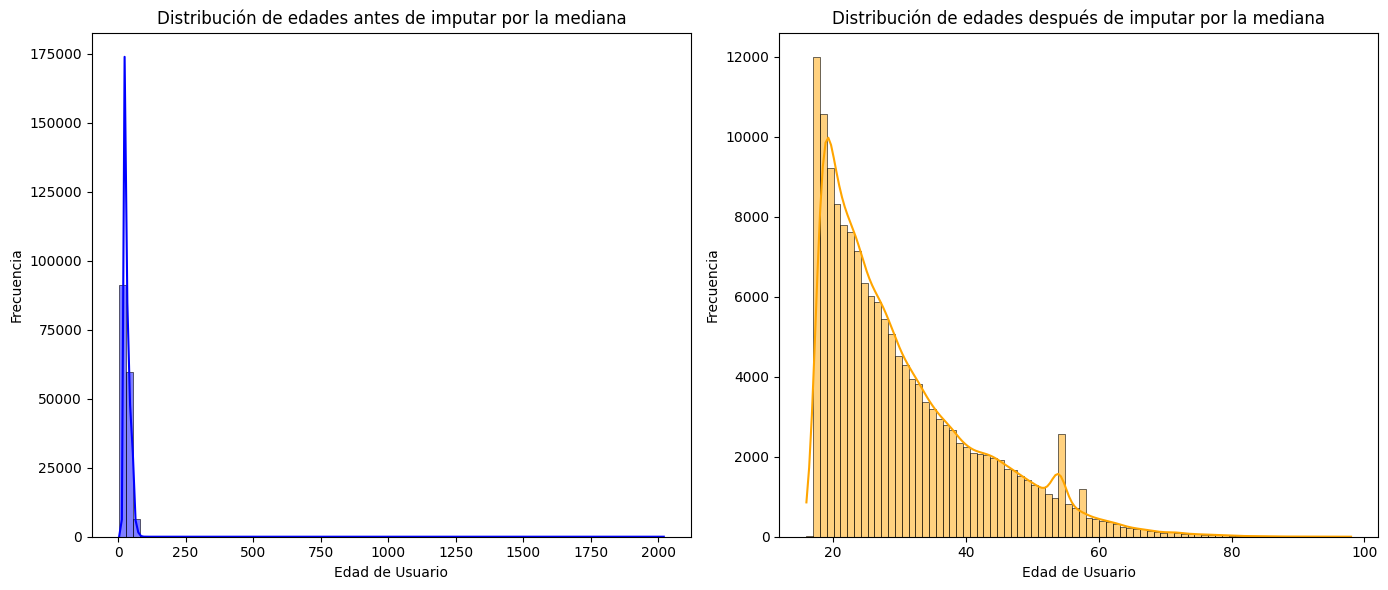

In [97]:
# ANÁLISIS DE PCA - SOLO ENCODING SENO
print(f"\n{'='*80}")
print("ANÁLISIS DE PCA - EXTRACCIÓN DE CARACTERÍSTICAS (SOLO SENO)")
print(f"{'='*80}")

# Aplicar PCA con dataset de solo encoding seno
scaler_seno = StandardScaler()
X_train_scaled_seno = scaler_seno.fit_transform(X_train_seno)
X_test_scaled_seno = scaler_seno.transform(X_test_seno)

print(f"Dataset escalado:")
print(f"  X_train_scaled_seno: {X_train_scaled_seno.shape}")
print(f"  X_test_scaled_seno: {X_test_scaled_seno.shape}")

# PCA completo para analizar varianza explicada
pca_full_seno = PCA()
X_train_pca_full_seno = pca_full_seno.fit_transform(X_train_scaled_seno)

varianza_explicada_seno = pca_full_seno.explained_variance_ratio_
varianza_acumulada_seno = np.cumsum(varianza_explicada_seno)

print(f"\nVarianza explicada por componente (primeros 10):")
for i in range(min(10, len(varianza_explicada_seno))):
    print(f"  PC{i+1}: {varianza_explicada_seno[i]*100:>6.2f}% (acum: {varianza_acumulada_seno[i]*100:>6.2f}%)")

# Encontrar número óptimo de componentes para 95% de varianza
n_comp_optimo_seno = np.argmax(varianza_acumulada_seno >= 0.95) + 1
print(f"\nComponentes necesarios para 95% de varianza: {n_comp_optimo_seno}")
print(f"Varianza explicada con {n_comp_optimo_seno} componentes: {varianza_acumulada_seno[n_comp_optimo_seno-1]*100:.2f}%")

# Aplicar PCA con número óptimo de componentes
pca_optimo_seno = PCA(n_components=n_comp_optimo_seno)
X_train_pca_seno = pca_optimo_seno.fit_transform(X_train_scaled_seno)
X_test_pca_seno = pca_optimo_seno.transform(X_test_scaled_seno)

print(f"\nDimensiones después de PCA:")
print(f"  Original: {X_train_scaled_seno.shape}")
print(f"  PCA:      {X_train_pca_seno.shape}")
print(f"  Reducción: {X_train_scaled_seno.shape[1]} → {X_train_pca_seno.shape[1]} features")
print(f"  Porcentaje: {100*X_train_pca_seno.shape[1]/X_train_scaled_seno.shape[1]:.1f}%")

# Análisis de componentes principales
print(f"\n{'='*60}")
print("ANÁLISIS DE COMPONENTES PRINCIPALES")
print(f"{'='*60}")

components_seno = pca_optimo_seno.components_
feature_names_seno = X_train_seno.columns

# Mostrar contribución de cada feature a los primeros componentes
n_comp_viz = min(5, n_comp_optimo_seno)
print(f"Contribución de features a los primeros {n_comp_viz} componentes:")

for i in range(n_comp_viz):
    print(f"\nComponente Principal {i+1} (varianza: {varianza_explicada_seno[i]*100:.2f}%):")
    
    # Obtener contribuciones absolutas y ordenar
    component_i = np.abs(components_seno[i])
    feature_contributions = list(zip(feature_names_seno, component_i))
    feature_contributions_sorted = sorted(feature_contributions, key=lambda x: x[1], reverse=True)
    
    # Mostrar top 5 contribuciones
    for j, (feature, contrib) in enumerate(feature_contributions_sorted[:5]):
        # Destacar si es variable seno
        marker = "🔄" if feature in variables_seno else "  "
        print(f"  {j+1}. {marker} {feature:<25}: {contrib:>6.3f}")

# Análisis específico de variables seno en PCA
print(f"\n{'='*60}")
print("ANÁLISIS DE VARIABLES SENO EN PCA")
print(f"{'='*60}")

for var_seno in variables_seno:
    if var_seno in feature_names_seno:
        idx = list(feature_names_seno).index(var_seno)
        print(f"\n{var_seno}:")
        for i in range(n_comp_viz):
            contrib = abs(components_seno[i, idx])
            print(f"  PC{i+1}: {contrib:>6.3f}")
        
        # Contribución total (suma de contribuciones absolutas a primeros componentes)
        contrib_total = sum(abs(components_seno[i, idx]) for i in range(n_comp_viz))
        print(f"  Total (PC1-{n_comp_viz}): {contrib_total:>6.3f}")

plt.tight_layout()
plt.show()

# VISUALIZACIÓN PCA Y RESUMEN FINAL - SOLO ENCODING SENO
print(f"\n{'='*60}")
print("GENERANDO VISUALIZACIONES DE PCA")
print(f"{'='*60}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Varianza explicada individual
components_nums = list(range(1, min(11, len(varianza_explicada_seno) + 1)))
bars1 = ax1.bar(components_nums, varianza_explicada_seno[:len(components_nums)] * 100, 
                color='skyblue', alpha=0.8)
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Varianza Explicada (%)')
ax1.set_title('Varianza Explicada por Componente\n(Solo Encoding Seno)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Destacar el punto de corte
for i, bar in enumerate(bars1):
    if i < n_comp_optimo_seno:
        bar.set_color('darkblue')
        bar.set_alpha(0.8)

# 2. Varianza explicada acumulada
ax2.plot(components_nums, varianza_acumulada_seno[:len(components_nums)] * 100, 
         'o-', linewidth=3, markersize=8, color='blue', label='Acumulada')
ax2.axhline(y=95, color='red', linestyle='--', linewidth=2, alpha=0.8, label='95% Umbral')
ax2.axvline(x=n_comp_optimo_seno, color='green', linestyle='--', linewidth=2, alpha=0.8, 
           label=f'Óptimo: {n_comp_optimo_seno} comp.')
ax2.set_xlabel('Número de Componentes Principales')
ax2.set_ylabel('Varianza Explicada Acumulada (%)')
ax2.set_title('Varianza Explicada Acumulada\n(Solo Encoding Seno)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Contribución de variables seno vs no-seno a PC1
if len(components_seno) > 0:
    pc1_contribs = np.abs(components_seno[0])
    
    # Separar contribuciones de variables seno vs no-seno
    seno_contribs = []
    no_seno_contribs = []
    
    for i, feature in enumerate(feature_names_seno):
        if feature in variables_seno:
            seno_contribs.append(pc1_contribs[i])
        else:
            no_seno_contribs.append(pc1_contribs[i])
    
    # Crear boxplot
    data_contribs = [seno_contribs, no_seno_contribs]
    labels_contribs = ['Variables Seno\n(3 vars)', f'Variables No-Seno\n({len(no_seno_contribs)} vars)']
    
    box_plot = ax3.boxplot(data_contribs, labels=labels_contribs, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('orange')
    box_plot['boxes'][1].set_facecolor('lightblue')
    
    ax3.set_ylabel('Contribución Absoluta a PC1')
    ax3.set_title('Distribución de Contribuciones a PC1\nSeno vs No-Seno', fontweight='bold')
    ax3.grid(True, alpha=0.3)

# 4. Resumen de reducción de dimensionalidad
metodos = ['Original', 'Features\nSeleccionadas\n(3+ técnicas)', f'PCA\n(95% var)']
dimensiones = [X_seno_only.shape[1], len(consensus_3plus_seno), n_comp_optimo_seno]

bars_reduccion = ax4.bar(metodos, dimensiones, 
                        color=['lightcoral', 'lightgreen', 'gold'])
ax4.set_ylabel('Número de Features/Componentes')
ax4.set_title('Comparación de Métodos de\nReducción de Dimensionalidad', fontweight='bold')

# Añadir valores y porcentajes
for i, (bar, dim) in enumerate(zip(bars_reduccion, dimensiones)):
    height = bar.get_height()
    if i == 0:
        percentage = 100
    else:
        percentage = (dim / dimensiones[0]) * 100
    
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{dim}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("RESUMEN FINAL - REDUCCIÓN DE DIMENSIONALIDAD (SOLO ENCODING SENO)")
print(f"{'='*80}")

print(f"Dataset original (con solo encoding seno): {X_seno_only.shape[1]} features")
print(f"  - Variables con encoding seno: {len(variables_seno)}")
print(f"  - Variables no temporales: {X_seno_only.shape[1] - len(variables_seno)}")

print(f"\nResultados de técnicas de selección:")
print(f"  - Pearson: {len(features_pearson_seno)} features")
print(f"  - Varianza: {len(features_varianza_seno)} features") 
print(f"  - ANOVA: {len(features_anova_seno)} features")
print(f"  - Kendall: {len(features_kendall_seno)} features")

print(f"\nConsensо entre técnicas:")
print(f"  - Consenso total (4/4): {len(consenso_total_seno)} features")
print(f"  - Consenso alto (3+/4): {len(consensus_3plus_seno)} features")

if consensus_3plus_seno:
    print(f"\nFeatures recomendadas (consenso 3+):")
    for i, (feature, count) in enumerate(consensus_3plus_seno_sorted, 1):
        marker = "🔄" if feature in variables_seno else "  "
        print(f"  {i:>2}. {marker} {feature:<25}: {count}/4 técnicas")

print(f"\nResultados de PCA:")
print(f"  - Componentes para 95% varianza: {n_comp_optimo_seno}")
print(f"  - Reducción PCA: {X_seno_only.shape[1]} → {n_comp_optimo_seno} ({100*n_comp_optimo_seno/X_seno_only.shape[1]:.1f}%)")

print(f"\nComparación de métodos de reducción:")
print(f"  1. Selección de features (consenso 3+): {X_seno_only.shape[1]} → {len(consensus_3plus_seno)} ({100*len(consensus_3plus_seno)/X_seno_only.shape[1]:.1f}%)")
print(f"  2. PCA (95% varianza): {X_seno_only.shape[1]} → {n_comp_optimo_seno} ({100*n_comp_optimo_seno/X_seno_only.shape[1]:.1f}%)")

# Variables finales guardadas
features_recomendadas_seno = [f[0] for f in consensus_3plus_seno_sorted]
print(f"\n{'='*60}")
print("VARIABLES DISPONIBLES PARA ANÁLISIS POSTERIOR")
print(f"{'='*60}")
print(f"  X_seno_only: dataset con solo encoding seno ({X_seno_only.shape})")
print(f"  features_recomendadas_seno: {len(features_recomendadas_seno)} features seleccionadas")
print(f"  X_train_pca_seno: datos entrenamiento con PCA ({X_train_pca_seno.shape})")
print(f"  X_test_pca_seno: datos prueba con PCA ({X_test_pca_seno.shape})")
print(f"  pca_optimo_seno: modelo PCA entrenado")
print(f"  scaler_seno: scaler para normalización")

print(f"\n🎯 RECOMENDACIÓN FINAL:")
print(f"Para máxima interpretabilidad: usar {len(features_recomendadas_seno)} features seleccionadas")
print(f"Para máxima reducción: usar {n_comp_optimo_seno} componentes PCA")
print(f"Encoding seno exitoso: {len([f for f in features_recomendadas_seno if f in variables_seno])}/3 variables seno seleccionadas")

In [98]:
# Limpieza final, quitamos las columnas que no se usan
if 'edad_usuario_winsorized' in users_df_train_cleaned.columns:
    users_df_train_cleaned.drop(columns=['edad_usuario_winsorized'], inplace=True)

### Recorridos

Se vio Más arriba en la etapa exploratoria que `duracion_recorrido` contiene muchos valores atípicos, incluso algunos por encima de los 40.000 minutos (~28 dias).<br>
Probablemente los valores altamente atípicos se debieron a bicicletas que no fueron devueltas (robadas) o a errores del sistema.

In [99]:
# Detectar outliers en duracion_recorrido usando método de IQR
Q1 = rides_df_train_cleaned['duracion_recorrido_min'].quantile(0.25)
Q3 = rides_df_train_cleaned['duracion_recorrido_min'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = rides_df_train_cleaned[(rides_df_train_cleaned['duracion_recorrido_min'] < lower_bound) | (rides_df_train_cleaned['duracion_recorrido_min'] > upper_bound)]

print(f"Outliers en duracion_recorrido (min): {outliers.shape[0]} ({outliers.shape[0] / rides_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers (min): {outliers['duracion_recorrido_min'].max()} (máximo), {outliers['duracion_recorrido_min'].min()} (mínimo)")
print(f"Conteo de valores de outliers:")
for valor, cantidad in outliers['duracion_recorrido_min'].value_counts().sort_index().items():
    print(f"{valor:.2f}: {cantidad}")

Outliers en duracion_recorrido (min): 157561 (5.600 % del total)
Valores de outliers (min): 42852.75 (máximo), 49.166666666666664 (mínimo)
Conteo de valores de outliers:
49.17: 126
49.18: 130
49.20: 137
49.22: 132
49.23: 148
49.25: 133
49.27: 127
49.28: 126
49.30: 130
49.32: 117
49.33: 120
49.35: 124
49.37: 132
49.38: 121
49.40: 130
49.42: 106
49.43: 118
49.45: 145
49.47: 127
49.48: 122
49.50: 124
49.52: 125
49.53: 132
49.55: 117
49.57: 131
49.58: 126
49.60: 121
49.62: 134
49.63: 114
49.65: 129
49.67: 136
49.68: 135
49.70: 122
49.72: 114
49.73: 139
49.75: 132
49.77: 118
49.78: 132
49.80: 123
49.82: 119
49.83: 117
49.85: 139
49.87: 146
49.88: 114
49.90: 116
49.92: 117
49.93: 143
49.95: 145
49.97: 130
49.98: 123
50.00: 135
50.02: 109
50.03: 134
50.05: 107
50.07: 105
50.08: 123
50.10: 98
50.12: 126
50.13: 144
50.15: 106
50.17: 120
50.18: 137
50.20: 130
50.22: 116
50.23: 126
50.25: 150
50.27: 139
50.28: 117
50.30: 112
50.32: 111
50.33: 111
50.35: 130
50.37: 141
50.38: 114
50.40: 116
50.42:

El método de IQR parece tomar valores perfectamente posibles (~49 min en adelante) como outliers.<br>
Incluso cambiando el factor multiplicador del IQR para hacerlo menos restrictivo sigue siendo demasiado acotado.<br>
Esto se debe a que este método funciona mejor para distribuciones relativamente simétricas, y `duracion_recorrido` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [100]:
# Outliers en duracion_recorrido usando método de desvio estandar (Z-score)
z_scores = np.abs(stats.zscore(rides_df_train_cleaned['duracion_recorrido_min']))
z_threshold = 3  # Umbral típico
outliers_z = rides_df_train_cleaned[z_scores > z_threshold]

print(f"Outliers detectados en duracion_recorrido (min) por Z-score: {outliers_z.shape[0]} ({outliers_z.shape[0] / rides_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers (min) usando Z-score: {outliers_z['duracion_recorrido_min'].max()} (máximo), {outliers_z['duracion_recorrido_min'].min()} (mínimo)")
print(f"\nConteo de valores de outliers por Z-score:")
for valor, cantidad in outliers_z['duracion_recorrido_min'].value_counts().sort_index().items():
    print(f"{valor:.2f}: {cantidad}")

Outliers detectados en duracion_recorrido (min) por Z-score: 1907 (0.068 % del total)
Valores de outliers (min) usando Z-score: 42852.75 (máximo), 507.9166666666667 (mínimo)

Conteo de valores de outliers por Z-score:
507.92: 1
508.28: 1
508.35: 1
508.38: 1
508.63: 1
508.97: 1
509.05: 1
509.45: 1
509.58: 1
510.13: 1
510.35: 1
510.62: 1
510.80: 1
510.95: 1
511.08: 1
511.10: 1
511.12: 1
511.15: 1
511.20: 2
511.23: 1
511.32: 1
512.00: 1
512.05: 1
512.85: 1
513.27: 1
513.32: 1
513.45: 1
513.52: 1
513.53: 1
514.10: 1
514.12: 1
514.58: 1
515.05: 1
515.25: 1
515.32: 1
515.45: 1
515.65: 1
515.70: 1
516.02: 1
516.03: 1
516.28: 1
516.32: 1
516.38: 1
516.53: 1
516.72: 1
517.48: 1
517.60: 1
518.42: 1
518.52: 1
518.60: 1
518.82: 1
519.17: 1
519.93: 1
520.18: 1
520.28: 1
520.37: 1
521.07: 1
522.02: 1
522.08: 1
522.10: 1
522.13: 1
522.65: 1
522.72: 1
523.27: 1
523.37: 1
523.78: 1
523.98: 1
524.30: 2
524.52: 1
524.55: 1
524.58: 1
524.63: 1
524.75: 1
524.83: 1
524.85: 1
525.00: 1
525.08: 1
525.10: 1
52

El método de desvio estandar (Z-score) parece funcionar mejor que el método de IQR, pero igualmente funciona mejor para distribuciones relativamente simétricas, y `duracion_recorrido` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [101]:
# Winsorización de duracion_recorrido en recorridos
rides_df_train_cleaned['duracion_recorrido_min_winsorized'] = winsorize_by_quantiles(rides_df_train_cleaned['duracion_recorrido_min'], lower_quantile=0.001, upper_quantile=0.9995)
print("Duración de recorridos (min) después de winsorización:")
print(rides_df_train_cleaned['duracion_recorrido_min_winsorized'].describe().apply(lambda x: f"{x:,.2f}"))
winsorized = rides_df_train_cleaned[rides_df_train_cleaned['duracion_recorrido_min'] != rides_df_train_cleaned['duracion_recorrido_min_winsorized']]
print(f"\nRegistros winsorizados: {winsorized.shape[0]} ({winsorized.shape[0] / rides_df_train_cleaned.shape[0] * 100:.3f} % del total)")

Duración de recorridos (min) después de winsorización:
count    2,813,643.00
mean            20.02
std             27.25
min              0.00
25%              8.37
50%             14.82
75%             24.68
max            643.99
Name: duracion_recorrido_min_winsorized, dtype: object

Registros winsorizados: 1407 (0.050 % del total)


# Feature engineering

Agregamos una feature derivada (si una fecha cae en feriado) cruzando con los datos de feriados Argentina 2024.<br>
Dicha columna se agrega a los conjuntos train y test dado que "feriado" no depende de ninguna información futura ni de la variable objetivo, es simplemente una transformación determinística de la fecha de cada recorrido, por ese motivo no hay data leakage.

In [103]:
import holidays

feriados_ar = holidays.Argentina(years=[2024])

In [104]:
# Indica si la fecha de origen del recorrido es feriado
rides_df_train_cleaned['feriado'] = rides_df_train_cleaned['fecha_origen_recorrido'].dt.date.isin(feriados_ar)
rides_df_test['feriado'] = rides_df_test['fecha_origen_recorrido'].dt.date.isin(feriados_ar)

In [105]:
# Verificación de feriados
mask_holiday = rides_df_train_cleaned['feriado'] == True
rides_df_train_cleaned[mask_holiday].sample(10)


,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,duracion_recorrido_min,mes,dia_semana_origen_recorrido,hora_origen_recorrido,duracion_recorrido_min_winsorized,feriado
1144967,21231376,485,2024-04-01 09:56:05,121,121 - YATAY,925 Yatay& Humahuaca,-58.428509,-34.601173,2024-04-01 10:04:10,161,161 - Humahuaca,3912 Humahuaca,-58.419676,-34.602078,727004,FIT,FEMALE,8.083333,4,Monday,9,8.083333,True
2546849,21141247,1875,2024-03-24 15:47:47,330,148 -La Paternal,PUNTA ARENAS 1798,-58.472127,-34.600831,2024-03-24 16:19:02,99,099 - Malabia,780 Malabia & Loyola,-58.435408,-34.596096,1132527,FIT,MALE,31.250000,3,Sunday,15,31.250000,True
1538074,23927742,1489,2024-11-18 21:34:42,281,350 - Plaza Irlanda,Av. Gaona 2200,-58.458315,-34.613778,2024-11-18 21:59:31,80,080 - VALLE,Valle 486,-58.434123,-34.624581,15286,ICONIC,MALE,24.816667,11,Monday,21,24.816667,True
426317,23398843,1085,2024-10-11 13:38:57,96,096 - Carlos Gardel,3302 Guardia Vieja & Aguero,-58.411659,-34.602781,2024-10-11 13:57:02,93,093 - CARLOS CALVO,Sarandi 1010,-58.394464,-34.620798,797755,FIT,MALE,18.083333,10,Friday,13,18.083333,True
773293,21201085,22,2024-03-28 15:14:09,107,107 - HOSPITAL GARRAHAN,Brasil 2290,-58.395844,-34.630377,2024-03-28 15:14:31,107,107 - HOSPITAL GARRAHAN,Brasil 2290,-58.395844,-34.630377,947868,FIT,MALE,0.366667,3,Thursday,15,0.366667,True
1898860,21202308,321,2024-03-28 16:41:16,516,368 - PLAZA DE LA SHOÁ,Av. Del Libertador 3899,-58.423347,-34.570998,2024-03-28 16:46:37,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,916974,ICONIC,FEMALE,5.350000,3,Thursday,16,5.350000,True
1272535,23407479,48,2024-10-12 14:40:38,368,378 - AGRONOMIA,Enzo Brdabehere 2897,-58.481323,-34.599938,2024-10-12 14:41:26,368,378 - AGRONOMIA,Enzo Brdabehere 2897,-58.481323,-34.599938,1222216,FIT,MALE,0.800000,10,Saturday,14,0.800000,True
730402,21141112,2849,2024-03-24 15:34:33,474,224 - BAIGORRIA,Baigorria 4101,-58.503020,-34.610892,2024-03-24 16:22:02,474,224 - BAIGORRIA,Baigorria 4101,-58.503020,-34.610892,1129489,FIT,FEMALE,47.483333,3,Sunday,15,47.483333,True
110275,23924459,1513,2024-11-18 16:25:15,281,350 - Plaza Irlanda,Av. Gaona 2200,-58.458315,-34.613778,2024-11-18 16:50:28,182,182 - RAVIGNANI Y GUATEMALA,"2185 Ravignani, Emilio, Dr. & Guatemala",-58.435247,-34.578048,687836,ICONIC,MALE,25.216667,11,Monday,16,25.216667,True
2470893,21572987,1770,2024-05-01 16:53:15,208,145 - RAVIGNANI,EMILIO RAVIGNANI 1802,-58.438404,-34.580716,2024-05-01 17:22:45,432,187 - Jose Maria Moreno,141 Jose Maria Moreno,-58.435801,-34.619879,13531,ICONIC,MALE,29.500000,5,Wednesday,16,29.500000,True


In [106]:
# 1. Distancia euclidiana entre estaciones
rides_df_train_cleaned['distancia_km'] = np.sqrt(
    (rides_df_train_cleaned['long_estacion_destino'] - rides_df_train_cleaned['long_estacion_origen'])**2 + 
    (rides_df_train_cleaned['lat_estacion_destino'] - rides_df_train_cleaned['lat_estacion_origen'])**2
) * 111  # Aproximación: 1 grado = 111 km

In [107]:
rides_df_train_cleaned

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,duracion_recorrido_min,mes,dia_semana_origen_recorrido,hora_origen_recorrido,duracion_recorrido_min_winsorized,feriado,distancia_km
0,21727397,824,2024-05-16 02:46:08,367,287 - Belaustegui,Belaustegui 2910,-58.477706,-34.616659,2024-05-16 02:59:52,368,378 - AGRONOMIA,Enzo Brdabehere 2897,-58.481323,-34.599938,641847,FIT,MALE,13.733333,5,Thursday,2,13.733333,False,1.898967
1,23155847,1329,2024-09-25 12:21:55,530,031 - PARQUE RIVADAVIA,Av Rivadavia 4950,-58.432350,-34.616511,2024-09-25 12:44:04,122,122 - COSTA RICA,COSTA RICA 4060,-58.419816,-34.591561,768173,FIT,FEMALE,22.150000,9,Wednesday,12,22.150000,False,3.099234
2,21547676,538,2024-04-29 08:28:06,183,183 - VIRREY CEVALLOS,Mexico 1652,-58.389973,-34.615699,2024-04-29 08:37:04,98,037- Claudia Pía Baudracco,Esmeralda y Rivadavia,-58.377900,-34.608164,468625,ICONIC,OTHER,8.966667,4,Monday,8,8.966667,False,1.579657
3,23605007,2726,2024-10-27 19:25:19,490,245 - COSTANERA NORTE,AV. Costanera Rafael del Obligado 1700,-58.402021,-34.564771,2024-10-27 20:10:45,12,012 - Plaza Vicente Lopez,Parana & Juncal,-58.388807,-34.592710,1128219,FIT,FEMALE,45.433333,10,Sunday,19,45.433333,False,3.430602
4,20420934,1174,2024-01-23 09:26:34,116,116 - HOSPITAL ALEMÁN,Juncal 2407,-58.401282,-34.591472,2024-01-23 09:46:08,51,051 - TUCUMAN,Tucuman & 9 De Julio Av.,-58.382126,-34.601478,1088385,FIT,MALE,19.566667,1,Tuesday,9,19.566667,False,2.398871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2813638,22755891,1780,2024-08-25 13:30:46,349,232 - Sucre y Martinez,Mcal. Antonio José de Sucre 3515,-58.466312,-34.570387,2024-08-25 14:00:26,483,175 - PLAZA MACKENNA,CRAMER 4500,-58.477126,-34.543689,1196292,ICONIC,FEMALE,29.666667,8,Sunday,13,29.666667,False,3.197348
2813639,20623047,343,2024-02-10 16:21:44,186,186 - MANZANA 66,2875 Moreno,-58.406441,-34.613636,2024-02-10 16:27:27,146,146 - Hospital Francés,"3024 Calvo, Carlos",-58.407842,-34.622112,124125,FIT,MALE,5.716667,2,Saturday,16,5.716667,False,0.953613
2813640,24223860,503,2024-12-09 14:16:19,181,181 - BILLINGHURST Y MANSILLA,"1520 Billinghurst & Mansilla, Lucio Norberto, ...",-58.412007,-34.592665,2024-12-09 14:24:42,33,033 - Facultad de Medicina,Pres. José Evaristo Uriburu 987,-58.398981,-34.597091,1127959,ICONIC,MALE,8.383333,12,Monday,14,8.383333,False,1.527124
2813641,22549902,794,2024-08-05 00:59:14,9,009 - Parque Las Heras,"2300 Diaz, Cnel. Av. & French",-58.407741,-34.585443,2024-08-05 01:12:28,54,054 - Acuña de Figueroa,Lavalle 4015,-58.422069,-34.598210,1155100,FIT,MALE,13.233333,8,Monday,0,13.233333,False,2.130193


=== ANÁLISIS: DISTANCIA VS USO DE ESTACIONES ===
Número de pares de estaciones analizados: 86388
Rango de distancias: 0.004 - 18.319 km
Rango de uso promedio: 280 - 29885 viajes


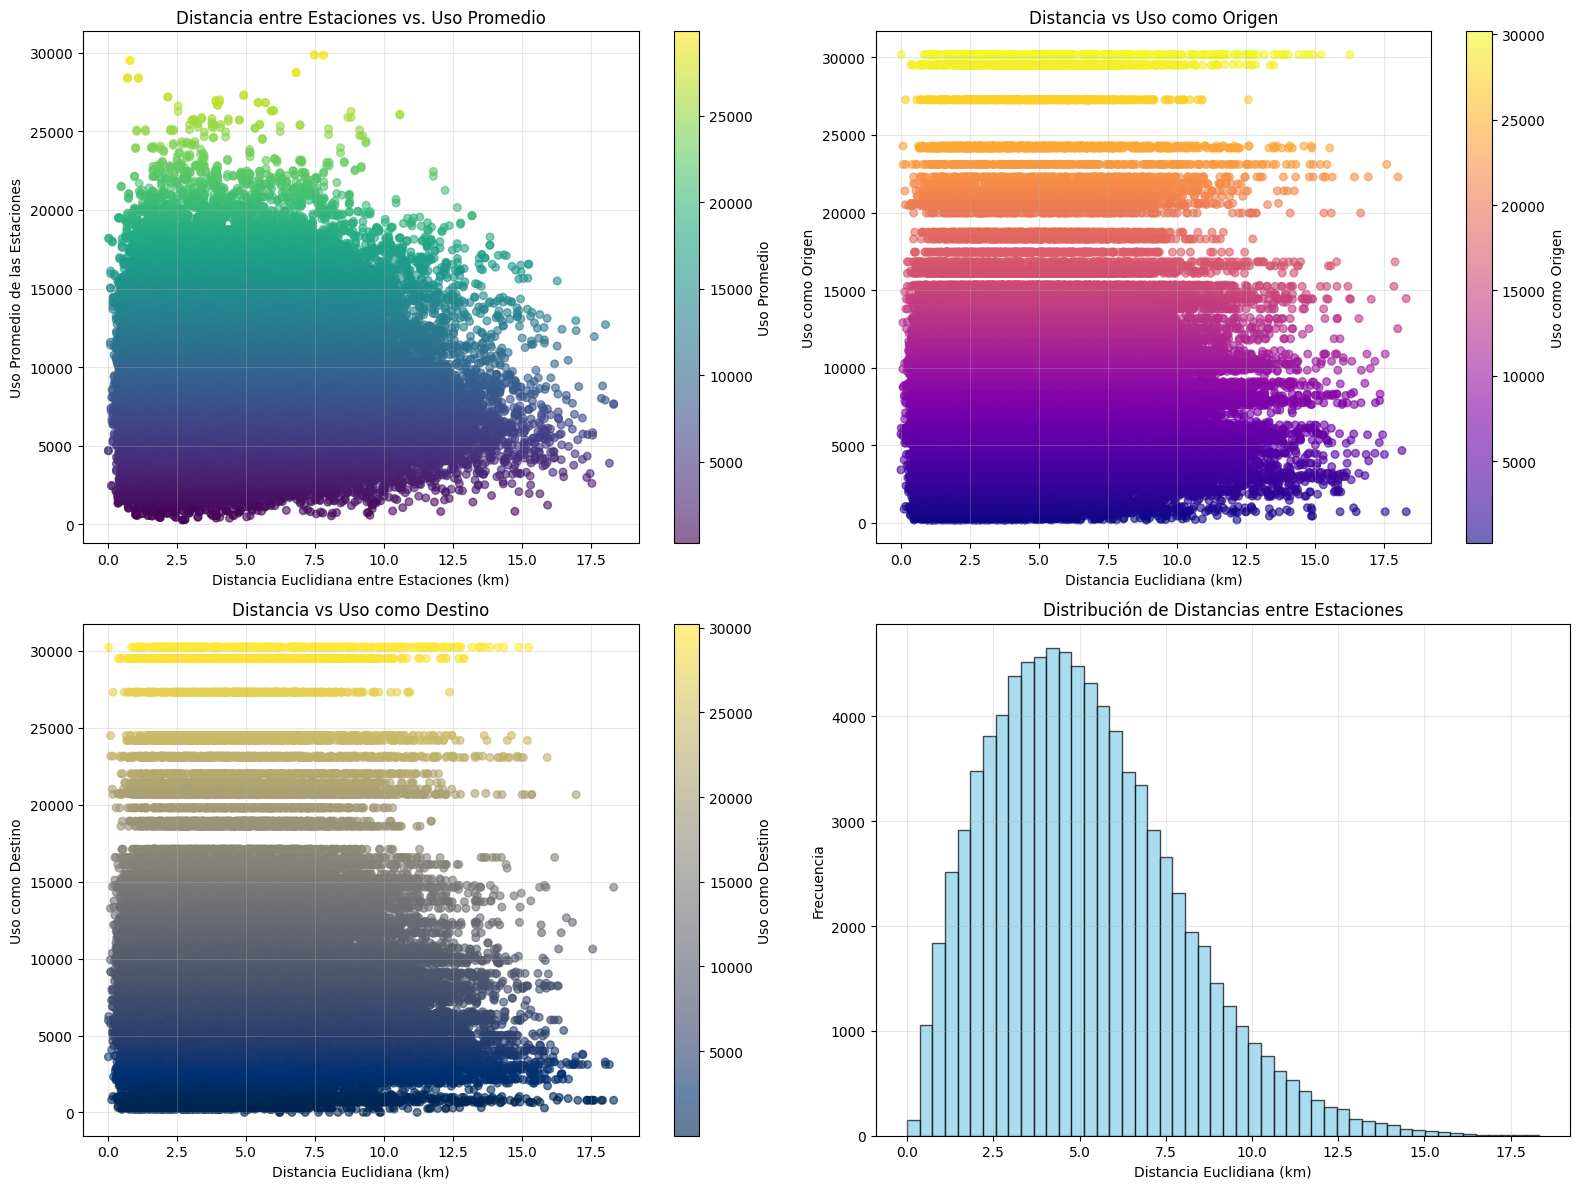


=== ANÁLISIS DE CORRELACIÓN ===
Correlación entre distancia y uso promedio: 0.025

=== TOP 10 PARES DE ESTACIONES MÁS UTILIZADOS ===
014 - Pacifico → 147 - Constitución
  Distancia: 7.471 km, Uso promedio: 29885 viajes

368 - PLAZA DE LA SHOÁ → 147 - Constitución
  Distancia: 7.800 km, Uso promedio: 29862 viajes

147 - Constitución → 368 - PLAZA DE LA SHOÁ
  Distancia: 7.800 km, Uso promedio: 29839 viajes

147 - Constitución → 014 - Pacifico
  Distancia: 7.471 km, Uso promedio: 29833 viajes

014 - Pacifico → 368 - PLAZA DE LA SHOÁ
  Distancia: 0.789 km, Uso promedio: 29518 viajes

368 - PLAZA DE LA SHOÁ → 014 - Pacifico
  Distancia: 0.789 km, Uso promedio: 29489 viajes

005 - Plaza Italia → 147 - Constitución
  Distancia: 6.810 km, Uso promedio: 28750 viajes

147 - Constitución → 005 - Plaza Italia
  Distancia: 6.810 km, Uso promedio: 28742 viajes

014 - Pacifico → 005 - Plaza Italia
  Distancia: 0.696 km, Uso promedio: 28421 viajes

368 - PLAZA DE LA SHOÁ → 005 - Plaza Italia
  Dista

In [109]:
# Gráfico: Distancia euclidiana entre estaciones vs. uso de esas estaciones
print("=== ANÁLISIS: DISTANCIA VS USO DE ESTACIONES ===")

# Calcular el uso de cada estación como origen y destino
uso_origen = rides_df_train_cleaned['nombre_estacion_origen'].value_counts().rename('uso_origen')
uso_destino = rides_df_train_cleaned['nombre_estacion_destino'].value_counts().rename('uso_destino')

# Crear DataFrame de pares de estaciones con su distancia promedio
pares_estaciones = rides_df_train_cleaned.groupby(['nombre_estacion_origen', 'nombre_estacion_destino']).agg({
    'distancia_km': 'mean'
}).reset_index()

# Filtrar solo pares de estaciones diferentes (origen ≠ destino)
pares_estaciones = pares_estaciones[pares_estaciones['nombre_estacion_origen'] != pares_estaciones['nombre_estacion_destino']]

# Agregar el uso de cada estación al DataFrame de pares
pares_estaciones = pares_estaciones.merge(uso_origen, left_on='nombre_estacion_origen', right_index=True, how='left')
pares_estaciones = pares_estaciones.merge(uso_destino, left_on='nombre_estacion_destino', right_index=True, how='left')

# Calcular el uso promedio entre origen y destino
pares_estaciones['uso_promedio'] = pares_estaciones[['uso_origen', 'uso_destino']].mean(axis=1)

print(f"Número de pares de estaciones analizados: {len(pares_estaciones)}")
print(f"Rango de distancias: {pares_estaciones['distancia_km'].min():.3f} - {pares_estaciones['distancia_km'].max():.3f} km")
print(f"Rango de uso promedio: {pares_estaciones['uso_promedio'].min():.0f} - {pares_estaciones['uso_promedio'].max():.0f} viajes")

# Crear visualización con múltiples gráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Scatter plot principal - Distancia vs Uso Promedio
scatter = axes[0,0].scatter(pares_estaciones['distancia_km'], pares_estaciones['uso_promedio'], 
                           alpha=0.6, s=30, c=pares_estaciones['uso_promedio'], cmap='viridis')
axes[0,0].set_xlabel('Distancia Euclidiana entre Estaciones (km)')
axes[0,0].set_ylabel('Uso Promedio de las Estaciones')
axes[0,0].set_title('Distancia entre Estaciones vs. Uso Promedio')
axes[0,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0,0], label='Uso Promedio')

# Gráfico 2: Distancia vs Uso como Origen
scatter2 = axes[0,1].scatter(pares_estaciones['distancia_km'], pares_estaciones['uso_origen'], 
                            alpha=0.6, s=30, c=pares_estaciones['uso_origen'], cmap='plasma')
axes[0,1].set_xlabel('Distancia Euclidiana (km)')
axes[0,1].set_ylabel('Uso como Origen')
axes[0,1].set_title('Distancia vs Uso como Origen')
axes[0,1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0,1], label='Uso como Origen')

# Gráfico 3: Distancia vs Uso como Destino
scatter3 = axes[1,0].scatter(pares_estaciones['distancia_km'], pares_estaciones['uso_destino'], 
                            alpha=0.6, s=30, c=pares_estaciones['uso_destino'], cmap='cividis')
axes[1,0].set_xlabel('Distancia Euclidiana (km)')
axes[1,0].set_ylabel('Uso como Destino')
axes[1,0].set_title('Distancia vs Uso como Destino')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1,0], label='Uso como Destino')

# Gráfico 4: Histograma de distancias
axes[1,1].hist(pares_estaciones['distancia_km'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].set_xlabel('Distancia Euclidiana (km)')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('Distribución de Distancias entre Estaciones')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de correlación
correlacion = pares_estaciones['distancia_km'].corr(pares_estaciones['uso_promedio'])
print(f"\n=== ANÁLISIS DE CORRELACIÓN ===")
print(f"Correlación entre distancia y uso promedio: {correlacion:.3f}")

# Top 10 pares de estaciones más utilizados
top_pares = pares_estaciones.nlargest(10, 'uso_promedio')[['nombre_estacion_origen', 'nombre_estacion_destino', 'distancia_km', 'uso_promedio']]
print(f"\n=== TOP 10 PARES DE ESTACIONES MÁS UTILIZADOS ===")
for idx, row in top_pares.iterrows():
    print(f"{row['nombre_estacion_origen']} → {row['nombre_estacion_destino']}")
    print(f"  Distancia: {row['distancia_km']:.3f} km, Uso promedio: {row['uso_promedio']:.0f} viajes\n")

# Preparación de datos para predicción de demanda en estaciones

Para predecir el congestionamiento/demanda en las estaciones, necesitamos crear un dataset agregado que capture:
- **Variable objetivo**: Demanda por estación y período temporal
- **Features temporales**: Hora, día de semana, mes, feriados
- **Features de estación**: Ubicación, características históricas de uso
- **Features contextuales**: Clima implícito via estacionalidad

El objetivo será predecir cuántos viajes **iniciarán** desde cada estación en un período dado (demanda de salida) para optimizar la distribución de bicicletas.

# Análisis de Reducción de Dimensionalidad

## Encoding Cíclico para Variables Temporales

Las variables temporales como **hora**, **día de la semana** y **mes** tienen una característica especial: son cíclicas por naturaleza. 

### Problema con el Encoding Numérico Lineal:
- **Hora**: 23 no está "lejos" de 0, sino que son consecutivas (23:59 → 00:00)
- **Día de semana**: Domingo (6) no está "lejos" de Lunes (0), sino que son consecutivos
- **Mes**: Diciembre (12) no está "lejos" de Enero (1), sino que son consecutivos

### Solución: Encoding Trigonométrico
Usaremos funciones **seno** y **coseno** para representar la naturaleza cíclica:
- Cada variable temporal se convierte en 2 variables: `sin` y `cos`
- Esto preserva la distancia cíclica real entre los valores

In [135]:
# REVISIÓN: DATASET SOLO CON ENCODING SENO
print("="*80)
print("REVISIÓN DEL ANÁLISIS - SOLO ENCODING SENO")
print("="*80)

# Crear dataset conservando solo variables seno (eliminando variables originales y coseno)
print("Creando dataset con solo encoding seno...")

# Identificar variables a eliminar
variables_a_eliminar = []

# 1. Variables temporales originales
variables_temporales_originales = ['hora', 'dia_semana', 'mes']
for col in X_cyclical_clean.columns:
    if col in variables_temporales_originales:
        variables_a_eliminar.append(col)
        print(f"  Eliminando variable original: {col}")

# 2. Variables con encoding coseno
variables_coseno = [col for col in X_cyclical_clean.columns if col.endswith('_cos')]
for col in variables_coseno:
    variables_a_eliminar.append(col)
    print(f"  Eliminando variable coseno: {col}")

print(f"\nTotal variables a eliminar: {len(variables_a_eliminar)}")
print(f"Variables eliminadas: {variables_a_eliminar}")

# Crear el nuevo dataset
X_seno_only = X_cyclical_clean.drop(columns=variables_a_eliminar)
print(f"\nDimensiones del dataset:")
print(f"  Original X_cyclical_clean: {X_cyclical_clean.shape}")
print(f"  Nuevo X_seno_only: {X_seno_only.shape}")
print(f"  Reducción: {X_cyclical_clean.shape[1]} → {X_seno_only.shape[1]} features")

print(f"\nVariables restantes en X_seno_only:")
for i, col in enumerate(X_seno_only.columns, 1):
    print(f"  {i:>2}. {col}")

# Identificar variables seno conservadas
variables_seno = [col for col in X_seno_only.columns if col.endswith('_sin')]
print(f"\nVariables con encoding seno conservadas: {len(variables_seno)}")
for var in variables_seno:
    print(f"  ✓ {var}")

# Crear splits de entrenamiento y prueba
print(f"\nCreando splits de entrenamiento y prueba...")
X_train_seno = X_seno_only.loc[X_train_cyclical.index]
X_test_seno = X_seno_only.loc[X_test_cyclical.index]

print(f"  X_train_seno: {X_train_seno.shape}")
print(f"  X_test_seno: {X_test_seno.shape}")

# Verificar que no hay datos faltantes
print(f"\nVerificación de datos faltantes:")
print(f"  X_seno_only: {X_seno_only.isnull().sum().sum()} valores nulos")
print(f"  X_train_seno: {X_train_seno.isnull().sum().sum()} valores nulos")
print(f"  X_test_seno: {X_test_seno.isnull().sum().sum()} valores nulos")

REVISIÓN DEL ANÁLISIS - SOLO ENCODING SENO
Creando dataset con solo encoding seno...
  Eliminando variable coseno: hora_cos
  Eliminando variable coseno: dia_semana_cos
  Eliminando variable coseno: mes_cos

Total variables a eliminar: 3
Variables eliminadas: ['hora_cos', 'dia_semana_cos', 'mes_cos']

Dimensiones del dataset:
  Original X_cyclical_clean: (546247, 24)
  Nuevo X_seno_only: (546247, 21)
  Reducción: 24 → 21 features

Variables restantes en X_seno_only:
   1. lat
   2. lon
   3. duracion_promedio
   4. duracion_std
   5. distancia_promedio
   6. distancia_std
   7. es_fin_semana
   8. es_hora_pico
   9. es_horario_laboral
  10. demanda_promedio_estacion
  11. demanda_std_estacion
  12. demanda_max_estacion
  13. demanda_min_estacion
  14. distancia_centro
  15. estacion_encoded
  16. genero_encoded
  17. estacion_año_encoded
  18. feriado_num
  19. hora_sin
  20. dia_semana_sin
  21. mes_sin

Variables con encoding seno conservadas: 3
  ✓ hora_sin
  ✓ dia_semana_sin
  ✓ me

In [136]:
# ANÁLISIS DE REDUCCIÓN DE DIMENSIONALIDAD - SOLO ENCODING SENO
print("="*80)
print("ANÁLISIS DE REDUCCIÓN DE DIMENSIONALIDAD CON SOLO ENCODING SENO")
print("="*80)

# Usar el dataset con solo encoding seno
X = X_seno_only.copy()
X_train = X_train_seno.copy()
X_test = X_test_seno.copy()

print(f"Dataset para análisis:")
print(f"  Features: {X.shape[1]}")
print(f"  Observaciones: {X.shape[0]}")
print(f"  Variables: {list(X.columns)}")

# 1. CORRELACIÓN DE PEARSON
print(f"\n{'='*60}")
print("1. CORRELACIÓN DE PEARSON")
print(f"{'='*60}")

correlaciones_pearson_seno = []
p_values_pearson_seno = []

for feature in X.columns:
    corr, p_val = pearsonr(X[feature], y)
    correlaciones_pearson_seno.append((feature, abs(corr), corr, p_val))
    p_values_pearson_seno.append(p_val)

# Ordenar por correlación absoluta
correlaciones_pearson_seno_sorted = sorted(correlaciones_pearson_seno, key=lambda x: x[1], reverse=True)

# Aplicar criterios de selección
umbral_corr_seno = 0.1
umbral_p_seno = 0.05

features_pearson_seno = []
print(f"Features seleccionadas por Correlación de Pearson (|r| > {umbral_corr_seno}, p < {umbral_p_seno}):")
for feature, abs_corr, corr, p_val in correlaciones_pearson_seno_sorted:
    if abs_corr > umbral_corr_seno and p_val < umbral_p_seno:
        features_pearson_seno.append(feature)
        significancia = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
        print(f"  ✓ {feature:<25}: r={corr:>7.4f}, p={p_val:>8.2e} {significancia}")

print(f"\nTotal features seleccionadas: {len(features_pearson_seno)}")

# 2. UMBRAL DE VARIANZA
print(f"\n{'='*60}")
print("2. UMBRAL DE VARIANZA")
print(f"{'='*60}")

# Crear selector de varianza
var_selector_seno = VarianceThreshold(threshold=0.1)
X_var_seno = var_selector_seno.fit_transform(X_train)

# Obtener features seleccionadas
features_seleccionadas_var_seno = X_train.columns[var_selector_seno.get_support()]
features_varianza_seno = list(features_seleccionadas_var_seno)

print(f"Features seleccionadas por Umbral de Varianza (threshold > 0.1):")
varianzas_seno = X_train.var()
for feature in features_varianza_seno:
    print(f"  ✓ {feature:<25}: varianza = {varianzas_seno[feature]:>8.4f}")

print(f"\nTotal features seleccionadas: {len(features_varianza_seno)}")

ANÁLISIS DE REDUCCIÓN DE DIMENSIONALIDAD CON SOLO ENCODING SENO
Dataset para análisis:
  Features: 21
  Observaciones: 546247
  Variables: ['lat', 'lon', 'duracion_promedio', 'duracion_std', 'distancia_promedio', 'distancia_std', 'es_fin_semana', 'es_hora_pico', 'es_horario_laboral', 'demanda_promedio_estacion', 'demanda_std_estacion', 'demanda_max_estacion', 'demanda_min_estacion', 'distancia_centro', 'estacion_encoded', 'genero_encoded', 'estacion_año_encoded', 'feriado_num', 'hora_sin', 'dia_semana_sin', 'mes_sin']

1. CORRELACIÓN DE PEARSON
Features seleccionadas por Correlación de Pearson (|r| > 0.1, p < 0.05):
  ✓ demanda_promedio_estacion: r= 0.4125, p=0.00e+00 ***
  ✓ demanda_std_estacion     : r= 0.4045, p=0.00e+00 ***
  ✓ demanda_max_estacion     : r= 0.3526, p=0.00e+00 ***
  ✓ distancia_std            : r= 0.3328, p=0.00e+00 ***
  ✓ lon                      : r= 0.2147, p=0.00e+00 ***
  ✓ distancia_centro         : r=-0.2280, p=0.00e+00 ***
  ✓ hora_sin                 : r=-

In [137]:
# 3. ANOVA F-TEST
print(f"\n{'='*60}")
print("3. ANOVA F-TEST")
print(f"{'='*60}")

# Aplicar ANOVA F-test
f_selector_seno = SelectKBest(score_func=f_classif, k='all')
X_anova_seno = f_selector_seno.fit_transform(X_train, y_train)

# Obtener scores
f_scores_seno = f_selector_seno.scores_
p_values_anova_seno = f_selector_seno.pvalues_

# Crear lista con información de cada feature
anova_results_seno = []
for i, feature in enumerate(X_train.columns):
    anova_results_seno.append((feature, f_scores_seno[i], p_values_anova_seno[i]))

# Ordenar por F-score
anova_results_seno_sorted = sorted(anova_results_seno, key=lambda x: x[1], reverse=True)

# Seleccionar features significativas
umbral_p_anova_seno = 0.05
features_anova_seno = []

print(f"Features seleccionadas por ANOVA F-test (p < {umbral_p_anova_seno}):")
for feature, f_score, p_val in anova_results_seno_sorted:
    if p_val < umbral_p_anova_seno:
        features_anova_seno.append(feature)
        significancia = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
        print(f"  ✓ {feature:<25}: F={f_score:>8.4f}, p={p_val:>8.2e} {significancia}")

print(f"\nTotal features seleccionadas: {len(features_anova_seno)}")

# 4. CORRELACIÓN DE KENDALL
print(f"\n{'='*60}")
print("4. CORRELACIÓN DE KENDALL")
print(f"{'='*60}")

correlaciones_kendall_seno = []
p_values_kendall_seno = []

for feature in X.columns:
    tau, p_val = kendalltau(X[feature], y)
    correlaciones_kendall_seno.append((feature, abs(tau), tau, p_val))
    p_values_kendall_seno.append(p_val)

# Ordenar por correlación absoluta
correlaciones_kendall_seno_sorted = sorted(correlaciones_kendall_seno, key=lambda x: x[1], reverse=True)

# Aplicar criterios de selección
umbral_tau_seno = 0.05
umbral_p_kendall_seno = 0.05

features_kendall_seno = []
print(f"Features seleccionadas por Correlación de Kendall (|τ| > {umbral_tau_seno}, p < {umbral_p_kendall_seno}):")
for feature, abs_tau, tau, p_val in correlaciones_kendall_seno_sorted:
    if abs_tau > umbral_tau_seno and p_val < umbral_p_kendall_seno:
        features_kendall_seno.append(feature)
        significancia = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
        print(f"  ✓ {feature:<25}: τ={tau:>7.4f}, p={p_val:>8.2e} {significancia}")

print(f"\nTotal features seleccionadas: {len(features_kendall_seno)}")

print(f"\n{'='*80}")
print("RESUMEN DE TÉCNICAS DE SELECCIÓN - SOLO ENCODING SENO")
print(f"{'='*80}")
print(f"Pearson:     {len(features_pearson_seno)} features")
print(f"Varianza:    {len(features_varianza_seno)} features")
print(f"ANOVA:       {len(features_anova_seno)} features")
print(f"Kendall:     {len(features_kendall_seno)} features")


3. ANOVA F-TEST
Features seleccionadas por ANOVA F-test (p < 0.05):
  ✓ distancia_std            : F=2604.0261, p=0.00e+00 ***
  ✓ demanda_promedio_estacion: F=977.7666, p=0.00e+00 ***
  ✓ demanda_std_estacion     : F=932.8961, p=0.00e+00 ***
  ✓ demanda_max_estacion     : F=682.6850, p=0.00e+00 ***
  ✓ es_fin_semana            : F=317.9543, p=0.00e+00 ***
  ✓ feriado_num              : F=311.8857, p=0.00e+00 ***
  ✓ hora_sin                 : F=304.5256, p=0.00e+00 ***
  ✓ distancia_centro         : F=303.8197, p=0.00e+00 ***
  ✓ lon                      : F=257.9831, p=0.00e+00 ***
  ✓ dia_semana_sin           : F=210.0200, p=0.00e+00 ***
  ✓ es_hora_pico             : F=141.0507, p=0.00e+00 ***
  ✓ es_horario_laboral       : F=138.6309, p=0.00e+00 ***
  ✓ estacion_encoded         : F=100.1077, p=0.00e+00 ***
  ✓ distancia_promedio       : F= 33.3662, p=0.00e+00 ***
  ✓ mes_sin                  : F= 17.5405, p=8.17e-276 ***
  ✓ genero_encoded           : F= 13.8020, p=4.91e-206 ***


## Aplicación de Técnicas de Reducción de Dimensionalidad

Aplicaremos todas las técnicas de selección y extracción de características utilizando el dataset con encoding cíclico para variables temporales:

In [138]:
# Ejecutar análisis de reducción de dimensionalidad con encoding cíclico
print("="*80)
print("ANÁLISIS DE REDUCCIÓN DE DIMENSIONALIDAD CON ENCODING CÍCLICO")
print("="*80)

# Usar el dataset con encoding cíclico
X_original = X.copy()  # Guardar el original para comparación
X = X_cyclical_clean.copy()  # Usar el dataset con encoding cíclico
X_train = X_train_cyclical.copy()
X_test = X_test_cyclical.copy()

print(f"Dataset con encoding cíclico:")
print(f"  Features: {X.shape[1]}")
print(f"  Observaciones: {X.shape[0]}")
print(f"  Variables: {list(X.columns)}")

# 1. CORRELACIÓN DE PEARSON
print(f"\n{'='*60}")
print("1. CORRELACIÓN DE PEARSON")
print(f"{'='*60}")

correlaciones_pearson_cyclical = []
p_values_pearson_cyclical = []

for feature in X.columns:
    corr, p_val = pearsonr(X[feature], y)
    correlaciones_pearson_cyclical.append((feature, abs(corr), corr, p_val))
    p_values_pearson_cyclical.append(p_val)

# Ordenar por correlación absoluta
correlaciones_pearson_cyclical_sorted = sorted(correlaciones_pearson_cyclical, key=lambda x: x[1], reverse=True)

# Aplicar criterios de selección
umbral_corr_cyclical = 0.1
umbral_p_cyclical = 0.05

features_pearson_cyclical = []
print(f"Features seleccionadas por Correlación de Pearson (|r| > {umbral_corr_cyclical}, p < {umbral_p_cyclical}):")
for feature, abs_corr, corr, p_val in correlaciones_pearson_cyclical_sorted:
    if abs_corr > umbral_corr_cyclical and p_val < umbral_p_cyclical:
        features_pearson_cyclical.append(feature)
        significancia = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
        print(f"  ✓ {feature:<25}: r={corr:>7.4f}, p={p_val:>8.2e} {significancia}")

print(f"\nTotal features seleccionadas: {len(features_pearson_cyclical)}")

# 2. UMBRAL DE VARIANZA
print(f"\n{'='*60}")
print("2. UMBRAL DE VARIANZA")
print(f"{'='*60}")

# Crear selector de varianza
var_selector_cyclical = VarianceThreshold(threshold=0.1)
X_var_cyclical = var_selector_cyclical.fit_transform(X_train)

# Obtener features seleccionadas
features_seleccionadas_var_cyclical = X_train.columns[var_selector_cyclical.get_support()]
features_varianza_cyclical = list(features_seleccionadas_var_cyclical)

print(f"Features seleccionadas por Umbral de Varianza (threshold > 0.1):")
varianzas_cyclical = X_train.var()
for feature in features_varianza_cyclical:
    print(f"  ✓ {feature:<25}: varianza = {varianzas_cyclical[feature]:>8.4f}")

print(f"\nTotal features seleccionadas: {len(features_varianza_cyclical)}")

ANÁLISIS DE REDUCCIÓN DE DIMENSIONALIDAD CON ENCODING CÍCLICO
Dataset con encoding cíclico:
  Features: 24
  Observaciones: 546247
  Variables: ['lat', 'lon', 'duracion_promedio', 'duracion_std', 'distancia_promedio', 'distancia_std', 'es_fin_semana', 'es_hora_pico', 'es_horario_laboral', 'demanda_promedio_estacion', 'demanda_std_estacion', 'demanda_max_estacion', 'demanda_min_estacion', 'distancia_centro', 'estacion_encoded', 'genero_encoded', 'estacion_año_encoded', 'feriado_num', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos']

1. CORRELACIÓN DE PEARSON
Dataset con encoding cíclico:
  Features: 24
  Observaciones: 546247
  Variables: ['lat', 'lon', 'duracion_promedio', 'duracion_std', 'distancia_promedio', 'distancia_std', 'es_fin_semana', 'es_hora_pico', 'es_horario_laboral', 'demanda_promedio_estacion', 'demanda_std_estacion', 'demanda_max_estacion', 'demanda_min_estacion', 'distancia_centro', 'estacion_encoded', 'genero_encoded', 'estacion_año_en

In [139]:
# 3. ANOVA F-TEST
print(f"\n{'='*60}")
print("3. ANOVA F-TEST")
print(f"{'='*60}")

# Aplicar ANOVA F-test
f_selector_cyclical = SelectKBest(score_func=f_classif, k='all')
X_anova_cyclical = f_selector_cyclical.fit_transform(X_train, y_train)

# Obtener scores
f_scores_cyclical = f_selector_cyclical.scores_
p_values_anova_cyclical = f_selector_cyclical.pvalues_

# Crear lista con información de cada feature
anova_results_cyclical = []
for i, feature in enumerate(X_train.columns):
    anova_results_cyclical.append((feature, f_scores_cyclical[i], p_values_anova_cyclical[i]))

# Ordenar por F-score
anova_results_cyclical_sorted = sorted(anova_results_cyclical, key=lambda x: x[1], reverse=True)

# Seleccionar features significativas
umbral_p_anova_cyclical = 0.05
features_anova_cyclical = []

print(f"Features seleccionadas por ANOVA F-test (p < {umbral_p_anova_cyclical}):")
for feature, f_score, p_val in anova_results_cyclical_sorted:
    if p_val < umbral_p_anova_cyclical:
        features_anova_cyclical.append(feature)
        significancia = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
        print(f"  ✓ {feature:<25}: F={f_score:>8.4f}, p={p_val:>8.2e} {significancia}")

print(f"\nTotal features seleccionadas: {len(features_anova_cyclical)}")

# 4. CORRELACIÓN DE KENDALL
print(f"\n{'='*60}")
print("4. CORRELACIÓN DE KENDALL")
print(f"{'='*60}")

correlaciones_kendall_cyclical = []
p_values_kendall_cyclical = []

for feature in X.columns:
    tau, p_val = kendalltau(X[feature], y)
    correlaciones_kendall_cyclical.append((feature, abs(tau), tau, p_val))
    p_values_kendall_cyclical.append(p_val)

# Ordenar por correlación absoluta
correlaciones_kendall_cyclical_sorted = sorted(correlaciones_kendall_cyclical, key=lambda x: x[1], reverse=True)

# Aplicar criterios de selección
umbral_tau_cyclical = 0.05
umbral_p_kendall_cyclical = 0.05

features_kendall_cyclical = []
print(f"Features seleccionadas por Correlación de Kendall (|τ| > {umbral_tau_cyclical}, p < {umbral_p_kendall_cyclical}):")
for feature, abs_tau, tau, p_val in correlaciones_kendall_cyclical_sorted:
    if abs_tau > umbral_tau_cyclical and p_val < umbral_p_kendall_cyclical:
        features_kendall_cyclical.append(feature)
        significancia = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
        print(f"  ✓ {feature:<25}: τ={tau:>7.4f}, p={p_val:>8.2e} {significancia}")

print(f"\nTotal features seleccionadas: {len(features_kendall_cyclical)}")

print(f"\n{'='*80}")
print("RESUMEN DE TÉCNICAS DE SELECCIÓN")
print(f"{'='*80}")
print(f"Pearson:     {len(features_pearson_cyclical)} features")
print(f"Varianza:    {len(features_varianza_cyclical)} features")
print(f"ANOVA:       {len(features_anova_cyclical)} features")
print(f"Kendall:     {len(features_kendall_cyclical)} features")


3. ANOVA F-TEST
Features seleccionadas por ANOVA F-test (p < 0.05):
  ✓ distancia_std            : F=2604.0261, p=0.00e+00 ***
  ✓ demanda_promedio_estacion: F=977.7666, p=0.00e+00 ***
  ✓ demanda_std_estacion     : F=932.8961, p=0.00e+00 ***
  ✓ demanda_max_estacion     : F=682.6850, p=0.00e+00 ***
  ✓ es_fin_semana            : F=317.9543, p=0.00e+00 ***
  ✓ feriado_num              : F=311.8857, p=0.00e+00 ***
  ✓ hora_sin                 : F=304.5256, p=0.00e+00 ***
  ✓ distancia_centro         : F=303.8197, p=0.00e+00 ***
  ✓ lon                      : F=257.9831, p=0.00e+00 ***
  ✓ dia_semana_sin           : F=210.0200, p=0.00e+00 ***
  ✓ hora_cos                 : F=191.7484, p=0.00e+00 ***
  ✓ es_hora_pico             : F=141.0507, p=0.00e+00 ***
  ✓ es_horario_laboral       : F=138.6309, p=0.00e+00 ***
  ✓ estacion_encoded         : F=100.1077, p=0.00e+00 ***
  ✓ distancia_promedio       : F= 33.3662, p=0.00e+00 ***
  ✓ dia_semana_cos           : F= 21.5660, p=0.00e+00 ***
  


MATRIZ DE INTERSECCIONES - FEATURES SELECCIONADAS



MATRIZ DE INTERSECCIONES - FEATURES SELECCIONADAS


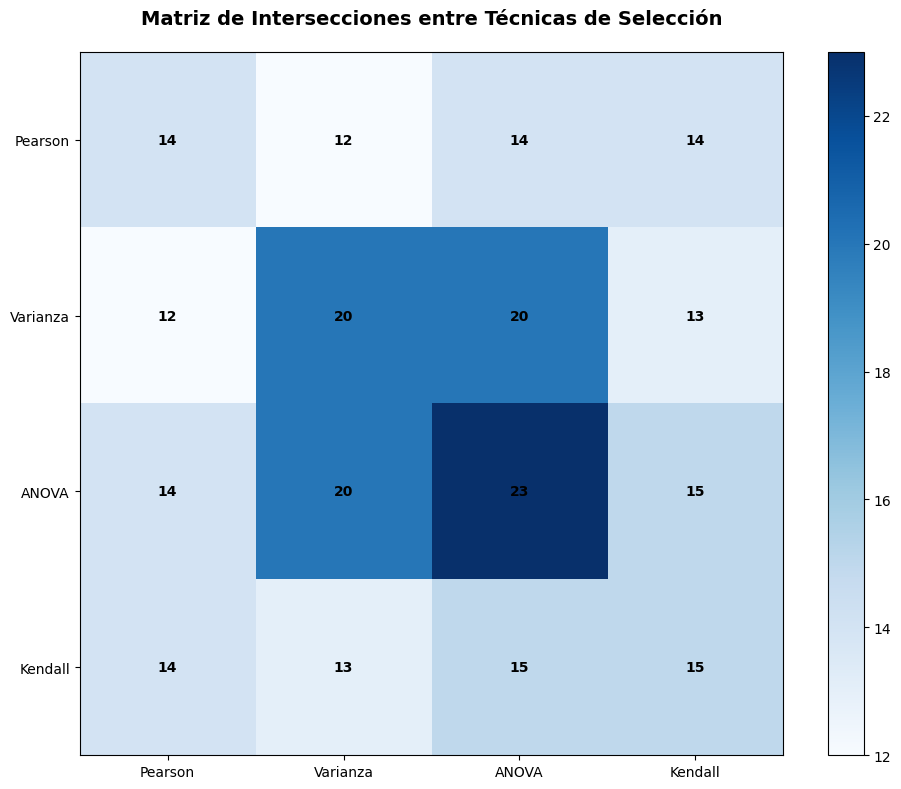


ANÁLISIS DETALLADO DE INTERSECCIONES

Pearson ∩ Varianza: 12 features
  ✓ demanda_max_estacion
  ✓ demanda_promedio_estacion
  ✓ demanda_std_estacion
  ✓ dia_semana_sin
  ✓ distancia_centro
  ✓ distancia_std
  ✓ es_fin_semana
  ✓ es_hora_pico
  ✓ es_horario_laboral
  ✓ estacion_encoded
  ✓ hora_cos
  ✓ hora_sin

Pearson ∩ ANOVA: 14 features
  ✓ demanda_max_estacion
  ✓ demanda_promedio_estacion
  ✓ demanda_std_estacion
  ✓ dia_semana_sin
  ✓ distancia_centro
  ✓ distancia_std
  ✓ es_fin_semana
  ✓ es_hora_pico
  ✓ es_horario_laboral
  ✓ estacion_encoded
  ✓ feriado_num
  ✓ hora_cos
  ✓ hora_sin
  ✓ lon

Pearson ∩ Kendall: 14 features
  ✓ demanda_max_estacion
  ✓ demanda_promedio_estacion
  ✓ demanda_std_estacion
  ✓ dia_semana_sin
  ✓ distancia_centro
  ✓ distancia_std
  ✓ es_fin_semana
  ✓ es_hora_pico
  ✓ es_horario_laboral
  ✓ estacion_encoded
  ✓ feriado_num
  ✓ hora_cos
  ✓ hora_sin
  ✓ lon

Varianza ∩ ANOVA: 20 features
  ✓ demanda_max_estacion
  ✓ demanda_promedio_estacion
  ✓ 

In [140]:
# Crear diccionario con técnicas de selección y sus features
tecnicas_seleccion_cyclical = ['Pearson', 'Varianza', 'ANOVA', 'Kendall']
tecnicas_features_cyclical = {
    'Pearson': features_pearson_cyclical,
    'Varianza': features_varianza_cyclical,
    'ANOVA': features_anova_cyclical,
    'Kendall': features_kendall_cyclical
}

# Crear sets para análisis de intersecciones
sets_seleccion_cyclical = [
    set(features_pearson_cyclical),
    set(features_varianza_cyclical), 
    set(features_anova_cyclical),
    set(features_kendall_cyclical)
]

# Crear matriz de intersecciones
n_tecnicas = len(tecnicas_seleccion_cyclical)
matriz_interseccion_cyclical = np.zeros((n_tecnicas, n_tecnicas))

for i in range(n_tecnicas):
    for j in range(n_tecnicas):
        interseccion = sets_seleccion_cyclical[i].intersection(sets_seleccion_cyclical[j])
        matriz_interseccion_cyclical[i, j] = len(interseccion)

print(f"\n{'='*80}")
print("MATRIZ DE INTERSECCIONES - FEATURES SELECCIONADAS")
print(f"{'='*80}")

# Mostrar la matriz
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(matriz_interseccion_cyclical, cmap='Blues')

# Configurar etiquetas
ax.set_xticks(np.arange(n_tecnicas))
ax.set_yticks(np.arange(n_tecnicas))
ax.set_xticklabels(tecnicas_seleccion_cyclical)
ax.set_yticklabels(tecnicas_seleccion_cyclical)

# Agregar valores en cada celda
for i in range(n_tecnicas):
    for j in range(n_tecnicas):
        text = ax.text(j, i, int(matriz_interseccion_cyclical[i, j]),
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title("Matriz de Intersecciones entre Técnicas de Selección", 
             fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im)
plt.tight_layout()
plt.show()

# Análisis detallado de intersecciones
print(f"\n{'='*60}")
print("ANÁLISIS DETALLADO DE INTERSECCIONES")
print(f"{'='*60}")

# Intersecciones de a pares
intersecciones_cyclical = {}
for i in range(n_tecnicas):
    for j in range(i+1, n_tecnicas):
        set_i = sets_seleccion_cyclical[i]
        set_j = sets_seleccion_cyclical[j]
        interseccion = set_i.intersection(set_j)
        tecnica_i = tecnicas_seleccion_cyclical[i]
        tecnica_j = tecnicas_seleccion_cyclical[j]
        intersecciones_cyclical[f"{tecnica_i} ∩ {tecnica_j}"] = interseccion
        
        print(f"\n{tecnica_i} ∩ {tecnica_j}: {len(interseccion)} features")
        if len(interseccion) > 0:
            for feature in sorted(interseccion):
                print(f"  ✓ {feature}")

# Intersección de todas las técnicas
todas_features_cyclical = set.union(*sets_seleccion_cyclical)
interseccion_todas_cyclical = set.intersection(*sets_seleccion_cyclical)

print(f"\n{'='*60}")
print("CONSENSO ENTRE TÉCNICAS")
print(f"{'='*60}")
print(f"Total features únicas seleccionadas: {len(todas_features_cyclical)}")
print(f"Features seleccionadas por TODAS las técnicas: {len(interseccion_todas_cyclical)}")

if len(interseccion_todas_cyclical) > 0:
    print("Features en consenso total:")
    for feature in sorted(interseccion_todas_cyclical):
        print(f"  ✓ {feature}")
else:
    print("No hay features seleccionadas por todas las técnicas")

# Features seleccionadas por 3 o más técnicas
consensus_3plus_cyclical = []
for feature in todas_features_cyclical:
    count = sum(1 for s in sets_seleccion_cyclical if feature in s)
    if count >= 3:
        consensus_3plus_cyclical.append((feature, count))

consensus_3plus_cyclical_sorted = sorted(consensus_3plus_cyclical, key=lambda x: x[1], reverse=True)

print(f"\nFeatures seleccionadas por 3+ técnicas: {len(consensus_3plus_cyclical)}")
for feature, count in consensus_3plus_cyclical_sorted:
    print(f"  ✓ {feature:<25}: {count}/4 técnicas")

In [141]:
# ANÁLISIS DETALLADO DE INTERSECCIONES 
print(f"\n{'='*80}")
print("ANÁLISIS DETALLADO DE INTERSECCIONES")
print(f"{'='*80}")

# Definir sets para facilitar el análisis
set_pearson_cyclical = set(features_pearson_cyclical)
set_varianza_cyclical = set(features_varianza_cyclical)
set_anova_cyclical = set(features_anova_cyclical)
set_kendall_cyclical = set(features_kendall_cyclical)

# Intersecciones por pares
intersecciones_cyclical = {
    'Pearson ∩ Varianza': set_pearson_cyclical & set_varianza_cyclical,
    'Pearson ∩ ANOVA': set_pearson_cyclical & set_anova_cyclical,
    'Pearson ∩ Kendall': set_pearson_cyclical & set_kendall_cyclical,
    'Varianza ∩ ANOVA': set_varianza_cyclical & set_anova_cyclical,
    'Varianza ∩ Kendall': set_varianza_cyclical & set_kendall_cyclical,
    'ANOVA ∩ Kendall': set_anova_cyclical & set_kendall_cyclical
}

print("Intersecciones por pares:")
for nombre, interseccion in intersecciones_cyclical.items():
    print(f"{nombre:<25}: {len(interseccion):>2} features")
    if interseccion:
        # Mostrar hasta 5 features y truncar si hay más
        features_mostrar = list(interseccion)[:5]
        features_str = ', '.join(features_mostrar)
        if len(interseccion) > 5:
            features_str += f' (+{len(interseccion)-5} más)'
        print(f"    {features_str}")

# Análisis de consenso por número de técnicas
consenso_data_cyclical = {}
for feature in todas_features_cyclical:
    count = sum(1 for s in sets_seleccion_cyclical if feature in s)
    if count not in consenso_data_cyclical:
        consenso_data_cyclical[count] = []
    consenso_data_cyclical[count].append(feature)

print(f"\n{'='*60}")
print("DISTRIBUCIÓN DE FEATURES POR NÚMERO DE TÉCNICAS")
print(f"{'='*60}")

for count in sorted(consenso_data_cyclical.keys(), reverse=True):
    features = consenso_data_cyclical[count]
    print(f"Seleccionadas por {count}/4 técnicas: {len(features)} features")
    if count >= 3:  # Mostrar detalles solo para consenso alto
        for feature in sorted(features):
            tecnicas_que_lo_seleccionan = []
            if feature in set_pearson_cyclical: tecnicas_que_lo_seleccionan.append('P')
            if feature in set_varianza_cyclical: tecnicas_que_lo_seleccionan.append('V')
            if feature in set_anova_cyclical: tecnicas_que_lo_seleccionan.append('A')
            if feature in set_kendall_cyclical: tecnicas_que_lo_seleccionan.append('K')
            print(f"  ✓ {feature:<25}: {'-'.join(tecnicas_que_lo_seleccionan)}")

# Análisis especial de variables cíclicas
print(f"\n{'='*60}")
print("ANÁLISIS DE VARIABLES CÍCLICAS")
print(f"{'='*60}")

variables_ciclicas = ['hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos']
ciclicas_en_pearson = [f for f in features_pearson_cyclical if any(ciclica in f for ciclica in variables_ciclicas)]
ciclicas_en_varianza = [f for f in features_varianza_cyclical if any(ciclica in f for ciclica in variables_ciclicas)]
ciclicas_en_anova = [f for f in features_anova_cyclical if any(ciclica in f for ciclica in variables_ciclicas)]
ciclicas_en_kendall = [f for f in features_kendall_cyclical if any(ciclica in f for ciclica in variables_ciclicas)]

print("Variables cíclicas seleccionadas por técnica:")
print(f"  Pearson:  {ciclicas_en_pearson}")
print(f"  Varianza: {ciclicas_en_varianza}")
print(f"  ANOVA:    {ciclicas_en_anova}")
print(f"  Kendall:  {ciclicas_en_kendall}")

# Recomendaciones finales
consenso_total_cyclical = set_pearson_cyclical & set_varianza_cyclical & set_anova_cyclical & set_kendall_cyclical
consensus_3plus_features = [feature for feature, count in consensus_3plus_cyclical_sorted]

print(f"\n{'='*80}")
print("RECOMENDACIONES FINALES")
print(f"{'='*80}")
print(f"Features con consenso total (4/4 técnicas): {len(consenso_total_cyclical)}")
print(f"Features con consenso alto (3+ técnicas): {len(consensus_3plus_features)}")
print(f"Total features únicas: {len(todas_features_cyclical)}")

if consenso_total_cyclical:
    print(f"\nFeatures ALTAMENTE RECOMENDADAS (consenso total):")
    for feature in sorted(consenso_total_cyclical):
        print(f"  ⭐ {feature}")

if consensus_3plus_features:
    print(f"\nFeatures RECOMENDADAS (consenso alto):")
    for feature in sorted(consensus_3plus_features):
        if feature not in consenso_total_cyclical:
            print(f"  ✓ {feature}")

features_recomendadas_consenso = list(consenso_total_cyclical) + [f for f in consensus_3plus_features if f not in consenso_total_cyclical]
print(f"\nTOTAL FEATURES RECOMENDADAS: {len(features_recomendadas_consenso)}")
print(f"Reducción: {len(X.columns)} → {len(features_recomendadas_consenso)} features ({100*len(features_recomendadas_consenso)/len(X.columns):.1f}%)")


ANÁLISIS DETALLADO DE INTERSECCIONES
Intersecciones por pares:
Pearson ∩ Varianza       : 12 features
    hora_cos, dia_semana_sin, es_hora_pico, distancia_centro, demanda_std_estacion (+7 más)
Pearson ∩ ANOVA          : 14 features
    hora_cos, feriado_num, dia_semana_sin, es_hora_pico, distancia_centro (+9 más)
Pearson ∩ Kendall        : 14 features
    hora_cos, feriado_num, dia_semana_sin, es_hora_pico, distancia_centro (+9 más)
Varianza ∩ ANOVA         : 20 features
    hora_cos, duracion_std, hora_sin, es_hora_pico, duracion_promedio (+15 más)
Varianza ∩ Kendall       : 13 features
    hora_cos, dia_semana_sin, distancia_centro, duracion_std, demanda_std_estacion (+8 más)
ANOVA ∩ Kendall          : 15 features
    hora_cos, feriado_num, dia_semana_sin, distancia_centro, duracion_std (+10 más)

DISTRIBUCIÓN DE FEATURES POR NÚMERO DE TÉCNICAS
Seleccionadas por 4/4 técnicas: 12 features
  ✓ demanda_max_estacion     : P-V-A-K
  ✓ demanda_promedio_estacion: P-V-A-K
  ✓ demanda_std_e

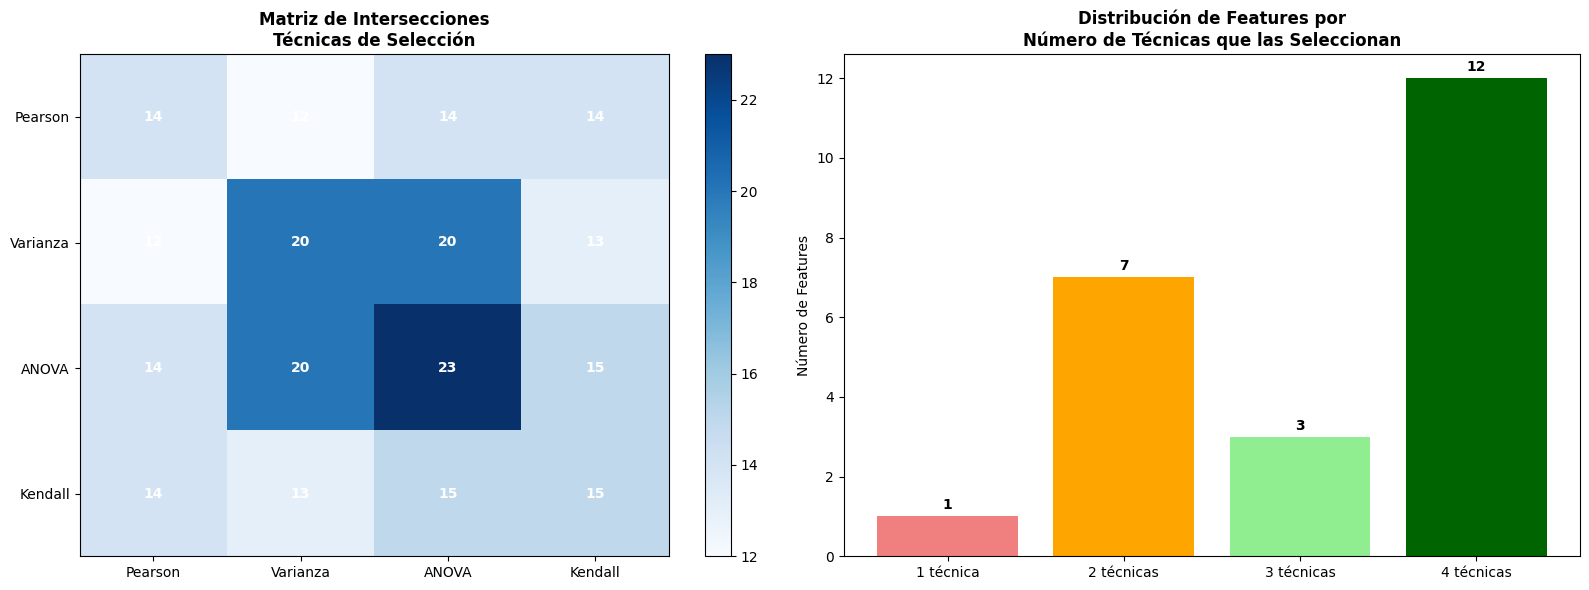


ANÁLISIS CUANTITATIVO FINAL
Distribución de features por número de técnicas:
  1 técnica:  1 features (  4.3%)
  2 técnicas:  7 features ( 30.4%)
  3 técnicas:  3 features ( 13.0%)
  4 técnicas: 12 features ( 52.2%)

Estadísticas de intersecciones:
  Intersección mínima: 12 features
  Intersección máxima: 20 features
  Intersección promedio: 14.7 features

Efectividad del encoding cíclico:
  Variables cíclicas seleccionadas: 6/6 posibles
  Representación en features finales: 26.1%

RECOMENDACIÓN FINAL DE FEATURES
Features recomendadas (consenso 3+): 15
Reducción de dimensionalidad: 24 → 15 (62.5%)

Features recomendadas:
   1. demanda_max_estacion      (seleccionada por 4/4 técnicas)
   2. demanda_promedio_estacion (seleccionada por 4/4 técnicas)
   3. demanda_std_estacion      (seleccionada por 4/4 técnicas)
   4. dia_semana_sin            (seleccionada por 4/4 técnicas)
   5. distancia_centro          (seleccionada por 4/4 técnicas)
   6. distancia_std             (seleccionada por 

In [142]:
# Visualización de la matriz de intersecciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Matriz de intersecciones
im1 = ax1.imshow(matriz_interseccion_cyclical, cmap='Blues', aspect='auto')
ax1.set_xticks(range(len(tecnicas_seleccion_cyclical)))
ax1.set_xticklabels(tecnicas_seleccion_cyclical)
ax1.set_yticks(range(len(tecnicas_seleccion_cyclical)))
ax1.set_yticklabels(tecnicas_seleccion_cyclical)
ax1.set_title('Matriz de Intersecciones\nTécnicas de Selección', fontweight='bold')

# Añadir valores en la matriz
for i in range(len(tecnicas_seleccion_cyclical)):
    for j in range(len(tecnicas_seleccion_cyclical)):
        ax1.text(j, i, f'{int(matriz_interseccion_cyclical[i, j])}', 
                ha='center', va='center', 
                color='white' if matriz_interseccion_cyclical[i, j] > matriz_interseccion_cyclical.max()/2 else 'black',
                fontweight='bold')

plt.colorbar(im1, ax=ax1)

# 2. Distribución de consenso
consenso_counts = [len(consenso_data_cyclical.get(i, [])) for i in range(1, 5)]
consenso_labels = ['1 técnica', '2 técnicas', '3 técnicas', '4 técnicas']

bars_consenso = ax2.bar(consenso_labels, consenso_counts, color=['lightcoral', 'orange', 'lightgreen', 'darkgreen'])
ax2.set_title('Distribución de Features por\nNúmero de Técnicas que las Seleccionan', fontweight='bold')
ax2.set_ylabel('Número de Features')

# Añadir valores en las barras
for bar, count in zip(bars_consenso, consenso_counts):
    if count > 0:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis cuantitativo
print(f"\n{'='*80}")
print("ANÁLISIS CUANTITATIVO FINAL")
print(f"{'='*80}")

# Distribución de selecciones
print("Distribución de features por número de técnicas:")
total_selections = sum(consenso_counts)
for i, (label, count) in enumerate(zip(consenso_labels, consenso_counts)):
    percentage = (count / total_selections * 100) if total_selections > 0 else 0
    print(f"  {label}: {count:>2} features ({percentage:>5.1f}%)")

# Estadísticas de intersecciones
print(f"\nEstadísticas de intersecciones:")
intersecciones_valores = [len(interseccion) for interseccion in intersecciones_cyclical.values()]
print(f"  Intersección mínima: {min(intersecciones_valores)} features")
print(f"  Intersección máxima: {max(intersecciones_valores)} features")
print(f"  Intersección promedio: {np.mean(intersecciones_valores):.1f} features")

# Efectividad del encoding cíclico
ciclicas_totales = len([f for f in todas_features_cyclical if any(ciclica in f for ciclica in ['sin', 'cos'])])
print(f"\nEfectividad del encoding cíclico:")
print(f"  Variables cíclicas seleccionadas: {ciclicas_totales}/6 posibles")
print(f"  Representación en features finales: {ciclicas_totales/len(todas_features_cyclical)*100:.1f}%")

# Recomendación final
print(f"\n{'='*60}")
print("RECOMENDACIÓN FINAL DE FEATURES")
print(f"{'='*60}")
features_recomendadas_3plus = [f[0] for f in consensus_3plus_cyclical_sorted]
print(f"Features recomendadas (consenso 3+): {len(features_recomendadas_3plus)}")
print(f"Reducción de dimensionalidad: {len(X.columns)} → {len(features_recomendadas_3plus)} ({100*len(features_recomendadas_3plus)/len(X.columns):.1f}%)")

print("\nFeatures recomendadas:")
for i, feature in enumerate(sorted(features_recomendadas_3plus), 1):
    tecnicas_count = sum(1 for s in sets_seleccion_cyclical if feature in s)
    print(f"  {i:>2}. {feature:<25} (seleccionada por {tecnicas_count}/4 técnicas)")

# Guardar features recomendadas para uso posterior
features_recomendadas_final = features_recomendadas_3plus.copy()
print(f"\nVariable 'features_recomendadas_final' guardada con {len(features_recomendadas_final)} features.")

In [150]:
# ANÁLISIS DE PCA (PRINCIPAL COMPONENT ANALYSIS)
print(f"\n{'='*80}")
print("ANÁLISIS DE PCA - EXTRACCIÓN DE CARACTERÍSTICAS")
print(f"{'='*80}")

# Aplicar PCA con encoding cíclico
scaler_cyclical = StandardScaler()
X_train_scaled_cyclical = scaler_cyclical.fit_transform(X_train_cyclical)
X_test_scaled_cyclical = scaler_cyclical.transform(X_test_cyclical)

# PCA completo para analizar varianza explicada
pca_full_cyclical = PCA()
X_train_pca_full_cyclical = pca_full_cyclical.fit_transform(X_train_scaled_cyclical)

varianza_explicada_cyclical = pca_full_cyclical.explained_variance_ratio_
varianza_acumulada_cyclical = np.cumsum(varianza_explicada_cyclical)

print(f"Varianza explicada por componente (primeros 10):")
for i in range(min(10, len(varianza_explicada_cyclical))):
    print(f"  PC{i+1}: {varianza_explicada_cyclical[i]*100:>6.2f}% (acum: {varianza_acumulada_cyclical[i]*100:>6.2f}%)")

# Encontrar número óptimo de componentes para 95% de varianza
n_comp_optimo_cyclical = np.argmax(varianza_acumulada_cyclical >= 0.95) + 1
print(f"\nComponentes necesarios para 95% de varianza: {n_comp_optimo_cyclical}")
print(f"Varianza explicada con {n_comp_optimo_cyclical} componentes: {varianza_acumulada_cyclical[n_comp_optimo_cyclical-1]*100:.2f}%")

# Aplicar PCA con número óptimo de componentes
pca_optimo_cyclical = PCA(n_components=n_comp_optimo_cyclical)
X_train_pca_cyclical = pca_optimo_cyclical.fit_transform(X_train_scaled_cyclical)
X_test_pca_cyclical = pca_optimo_cyclical.transform(X_test_scaled_cyclical)

print(f"\nDimensiones después de PCA:")
print(f"  Original: {X_train_scaled_cyclical.shape}")
print(f"  PCA:      {X_train_pca_cyclical.shape}")
print(f"  Reducción: {X_train_scaled_cyclical.shape[1]} → {X_train_pca_cyclical.shape[1]} features")

# Análisis de componentes principales
print(f"\n{'='*60}")
print("ANÁLISIS DE COMPONENTES PRINCIPALES")
print(f"{'='*60}")

components = pca_optimo_cyclical.components_
feature_names = X_train_cyclical.columns

# Mostrar contribución de cada feature a los primeros componentes
n_comp_viz = min(5, n_comp_optimo_cyclical)
print(f"Contribución de features a los primeros {n_comp_viz} componentes:")

for i in range(n_comp_viz):
    print(f"\nComponente Principal {i+1} (varianza: {varianza_explicada_cyclical[i]*100:.2f}%):")
    
    # Obtener contribuciones absolutas y ordenar
    component_i = np.abs(components[i])
    feature_contributions = list(zip(feature_names, component_i))
    feature_contributions_sorted = sorted(feature_contributions, key=lambda x: x[1], reverse=True)
    
    # Mostrar top 5 contribuciones
    for j, (feature, contrib) in enumerate(feature_contributions_sorted[:5]):
        print(f"  {j+1}. {feature:<25}: {contrib:>6.3f}")

print(f"\n{'='*80}")
print("RESUMEN FINAL - REDUCCIÓN DE DIMENSIONALIDAD")
print(f"{'='*80}")
print(f"Dataset original: {X.shape[1]} features")
print(f"Features recomendadas por selección (consenso 3+): {len(features_recomendadas_3plus)}")
print(f"Componentes PCA para 95% varianza: {n_comp_optimo_cyclical}")
print(f"\nOpciones de reducción:")
print(f"  1. Selección de features: {X.shape[1]} → {len(features_recomendadas_3plus)} ({100*len(features_recomendadas_3plus)/X.shape[1]:.1f}%)")
print(f"  2. PCA: {X.shape[1]} → {n_comp_optimo_cyclical} ({100*n_comp_optimo_cyclical/X.shape[1]:.1f}%)")
print(f"  3. Combinado: usar features seleccionadas + PCA para mayor reducción")

# Variables disponibles para análisis posterior
print(f"\n{'='*60}")
print("VARIABLES DISPONIBLES PARA ANÁLISIS POSTERIOR")
print(f"{'='*60}")
print(f"  features_recomendadas_final: {len(features_recomendadas_final)} features seleccionadas")
print(f"  X_train_pca_cyclical: datos de entrenamiento con PCA ({X_train_pca_cyclical.shape})")
print(f"  X_test_pca_cyclical: datos de prueba con PCA ({X_test_pca_cyclical.shape})")
print(f"  pca_optimo_cyclical: modelo PCA entrenado")
print(f"  scaler_cyclical: scaler para normalización")


ANÁLISIS DE PCA - EXTRACCIÓN DE CARACTERÍSTICAS
Varianza explicada por componente (primeros 10):
  PC1:  17.24% (acum:  17.24%)
  PC2:   8.51% (acum:  25.74%)
  PC3:   8.02% (acum:  33.77%)
  PC4:   7.70% (acum:  41.47%)
  PC5:   7.15% (acum:  48.62%)
  PC6:   5.97% (acum:  54.59%)
  PC7:   5.49% (acum:  60.08%)
  PC8:   4.94% (acum:  65.02%)
  PC9:   4.65% (acum:  69.67%)
  PC10:   4.44% (acum:  74.11%)

Componentes necesarios para 95% de varianza: 16
Varianza explicada con 16 componentes: 95.80%

Dimensiones después de PCA:
  Original: (436997, 24)
  PCA:      (436997, 16)
  Reducción: 24 → 16 features

ANÁLISIS DE COMPONENTES PRINCIPALES
Contribución de features a los primeros 5 componentes:

Componente Principal 1 (varianza: 17.24%):
  1. demanda_std_estacion     :  0.457
  2. demanda_promedio_estacion:  0.454
  3. demanda_max_estacion     :  0.418
  4. distancia_centro         :  0.410
  5. lon                      :  0.402

Componente Principal 2 (varianza: 8.51%):
  1. estacion

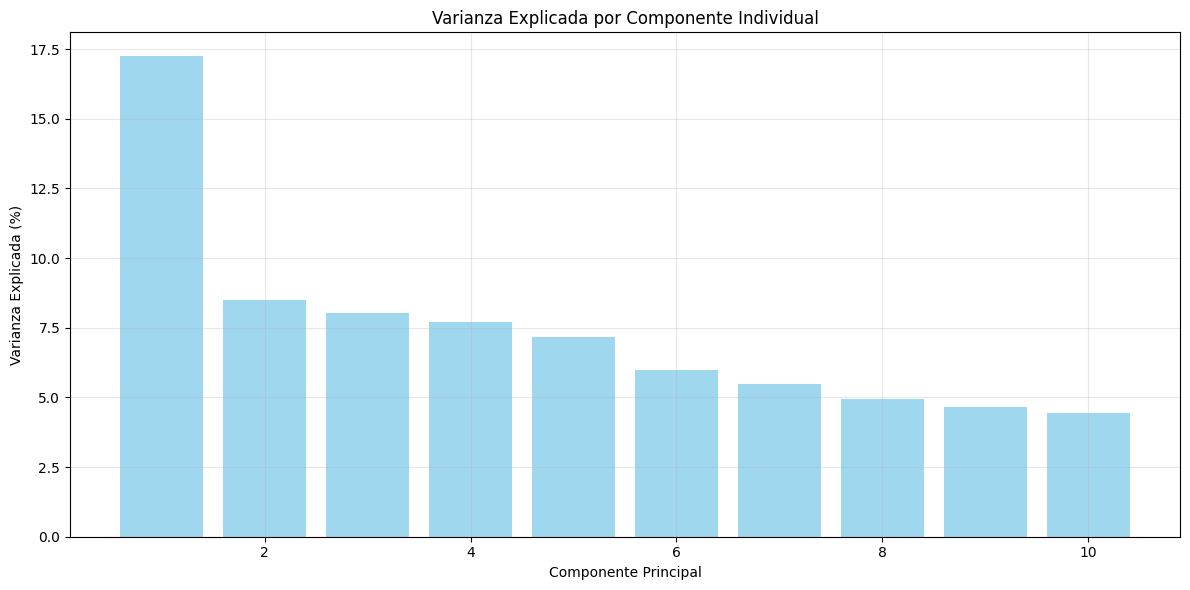

In [151]:
# GRÁFICO 1: Varianza explicada por componente individual
plt.figure(figsize=(12, 6))
components_nums = list(range(1, min(11, len(varianza_explicada_cyclical) + 1)))
plt.bar(components_nums, varianza_explicada_cyclical[:len(components_nums)] * 100, 
        color='skyblue', alpha=0.8)
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada (%)')
plt.title('Varianza Explicada por Componente Individual')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

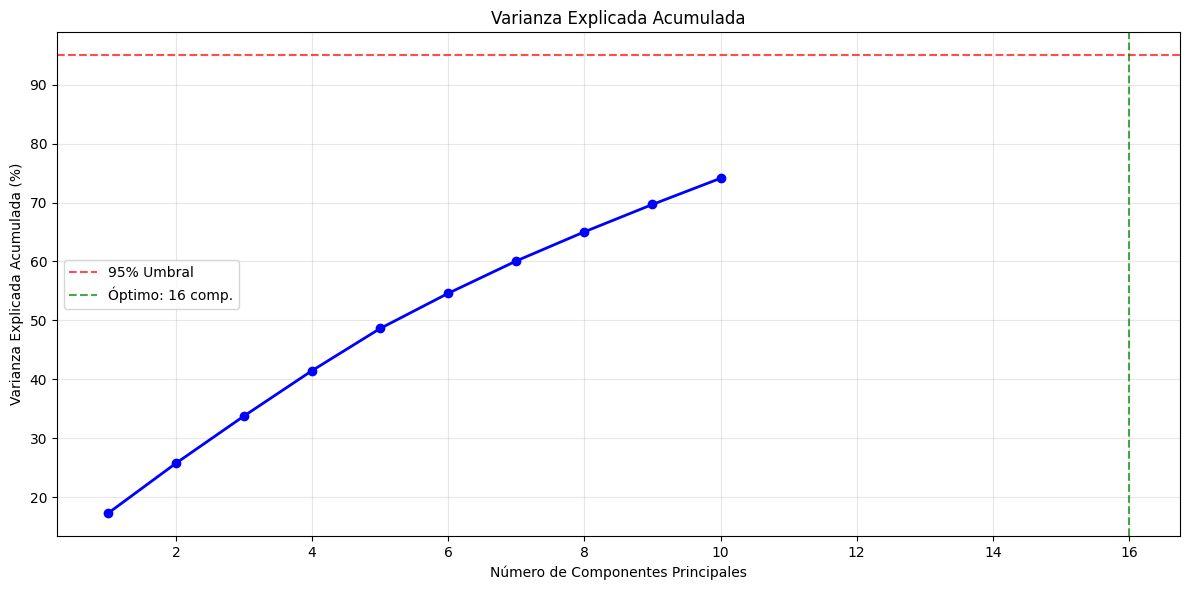

In [152]:
# GRÁFICO 2: Varianza explicada acumulada
plt.figure(figsize=(12, 6))
plt.plot(components_nums, varianza_acumulada_cyclical[:len(components_nums)] * 100, 
         'o-', linewidth=2, markersize=6, color='blue')
plt.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% Umbral')
plt.axvline(x=n_comp_optimo_cyclical, color='green', linestyle='--', alpha=0.7, 
           label=f'Óptimo: {n_comp_optimo_cyclical} comp.')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada (%)')
plt.title('Varianza Explicada Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

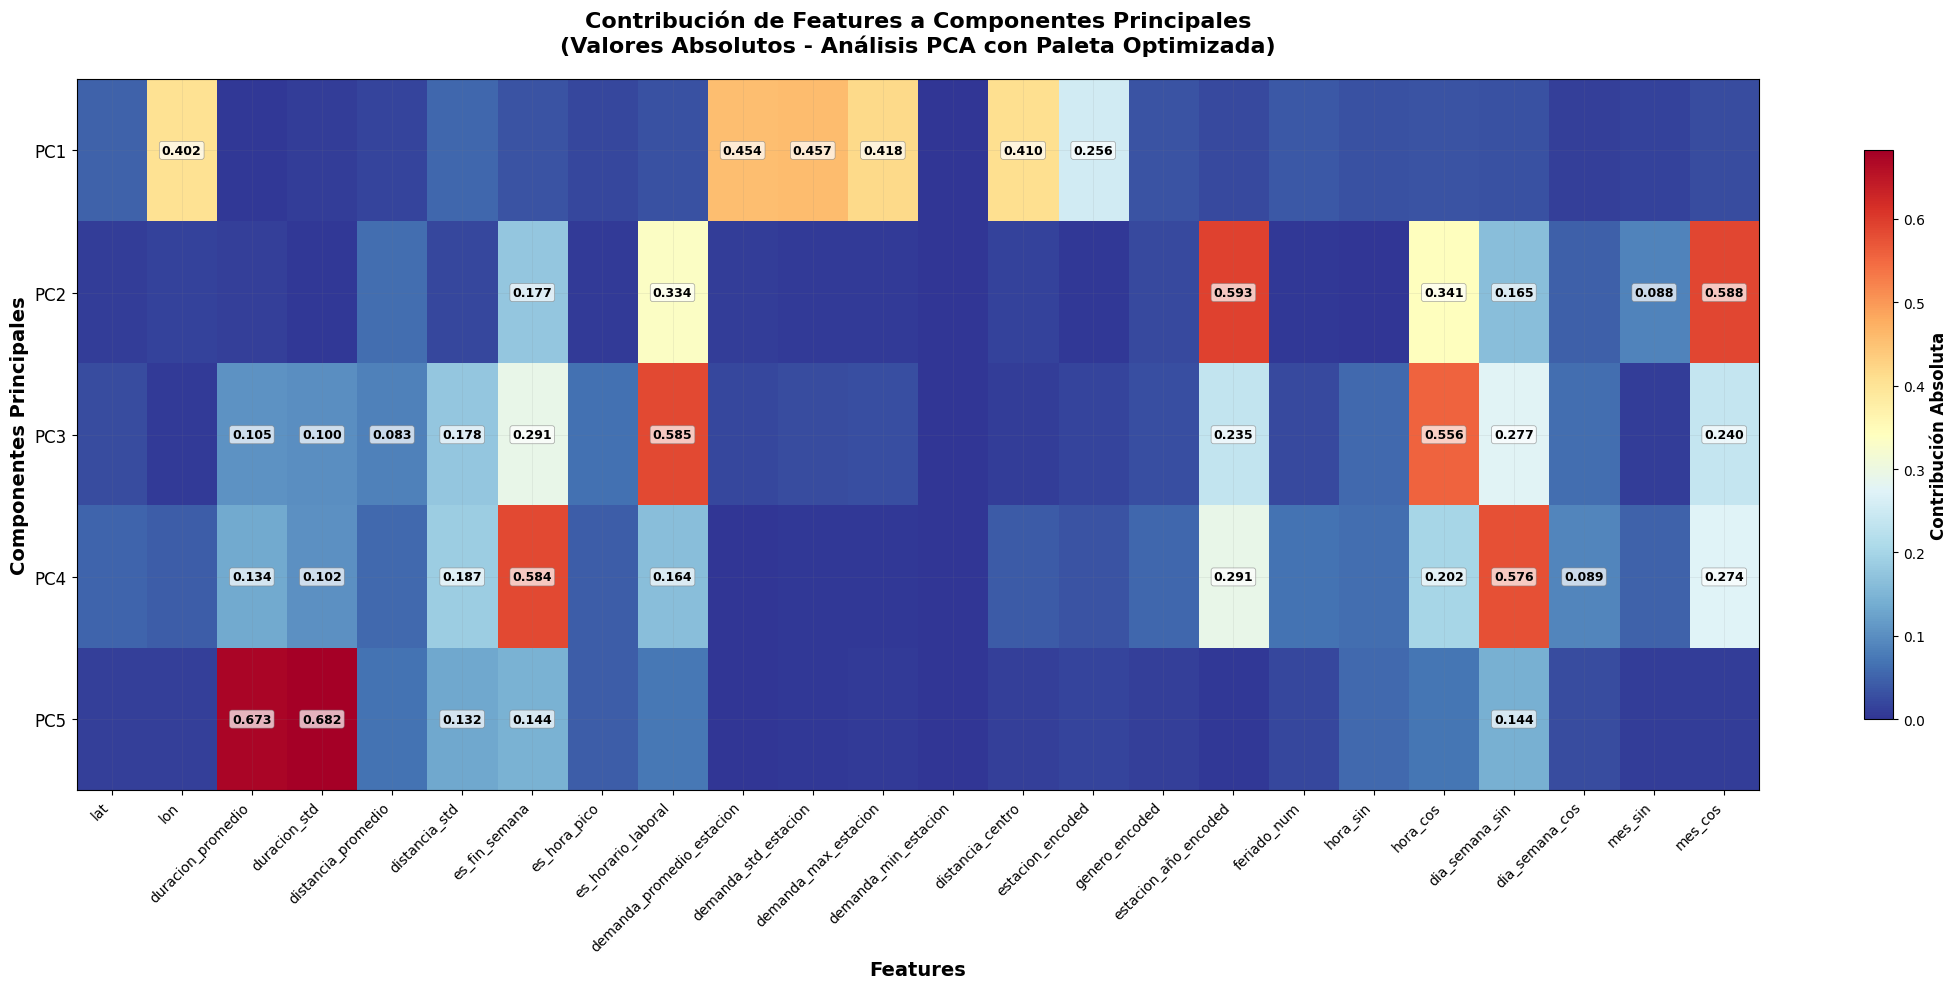


ESTADÍSTICAS DEL HEATMAP DE CONTRIBUCIONES
📊 Paleta utilizada: RdYlBu_r (Rojo-Amarillo-Azul invertida)
📈 Valor máximo de contribución: 0.6822
📉 Valor mínimo de contribución: 0.0000
🎯 Umbral para mostrar números: 0.0819
🔢 Valores mostrados: 38 de 120
📊 Porcentaje de valores mostrados: 31.7%

💡 Todos los números tienen formato uniforme: color negro, negrita y mismo tamaño para máxima consistencia


In [165]:
# GRÁFICO 3: Heatmap de contribuciones de features a componentes principales
plt.figure(figsize=(22, 10))
contributions_matrix = np.abs(components[:n_comp_viz, :])

# Usar la paleta más recomendada para visibilidad de números
im = plt.imshow(contributions_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

# Configurar etiquetas del eje X con mejor espaciado
step = max(1, len(feature_names)//15)  # Mostrar más etiquetas para mejor legibilidad
x_ticks = range(0, len(feature_names), step)
x_labels = [feature_names[i] for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45, ha='right', fontsize=10)

# Configurar etiquetas del eje Y
plt.yticks(range(n_comp_viz), [f'PC{i+1}' for i in range(n_comp_viz)], fontsize=12)

# Sistema optimizado de números para RdYlBu_r
threshold = np.max(contributions_matrix) * 0.12  # Umbral más bajo para mostrar más valores
max_val = np.max(contributions_matrix)

for i in range(n_comp_viz):
    for j in range(len(feature_names)):
        value = contributions_matrix[i, j]
        if value > threshold:  # Solo mostrar valores significativos
            # Todos los números con formato uniforme: negro, negrita, mismo tamaño
            plt.text(j, i, f'{value:.3f}', ha='center', va='center', 
                    fontsize=9, color='black', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='gray', linewidth=0.5))

# Mejorar títulos y etiquetas
plt.xlabel('Features', fontsize=14, fontweight='bold')
plt.ylabel('Componentes Principales', fontsize=14, fontweight='bold')
plt.title('Contribución de Features a Componentes Principales\n(Valores Absolutos - Análisis PCA con Paleta Optimizada)', 
          fontsize=16, fontweight='bold', pad=20)

# Colorbar mejorada
cbar = plt.colorbar(im, label='Contribución Absoluta', shrink=0.8)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Contribución Absoluta', fontsize=12, fontweight='bold')

# Agregar grid sutil para mejor legibilidad
plt.grid(True, alpha=0.15, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()

# Mostrar estadísticas del heatmap
print(f"\n{'='*60}")
print("ESTADÍSTICAS DEL HEATMAP DE CONTRIBUCIONES")
print(f"{'='*60}")
print(f"📊 Paleta utilizada: RdYlBu_r (Rojo-Amarillo-Azul invertida)")
print(f"📈 Valor máximo de contribución: {max_val:.4f}")
print(f"📉 Valor mínimo de contribución: {np.min(contributions_matrix):.4f}")
print(f"🎯 Umbral para mostrar números: {threshold:.4f}")
print(f"🔢 Valores mostrados: {np.sum(contributions_matrix > threshold)} de {contributions_matrix.size}")
print(f"📊 Porcentaje de valores mostrados: {100 * np.sum(contributions_matrix > threshold) / contributions_matrix.size:.1f}%")
print(f"\n💡 Todos los números tienen formato uniforme: color negro, negrita y mismo tamaño para máxima consistencia")

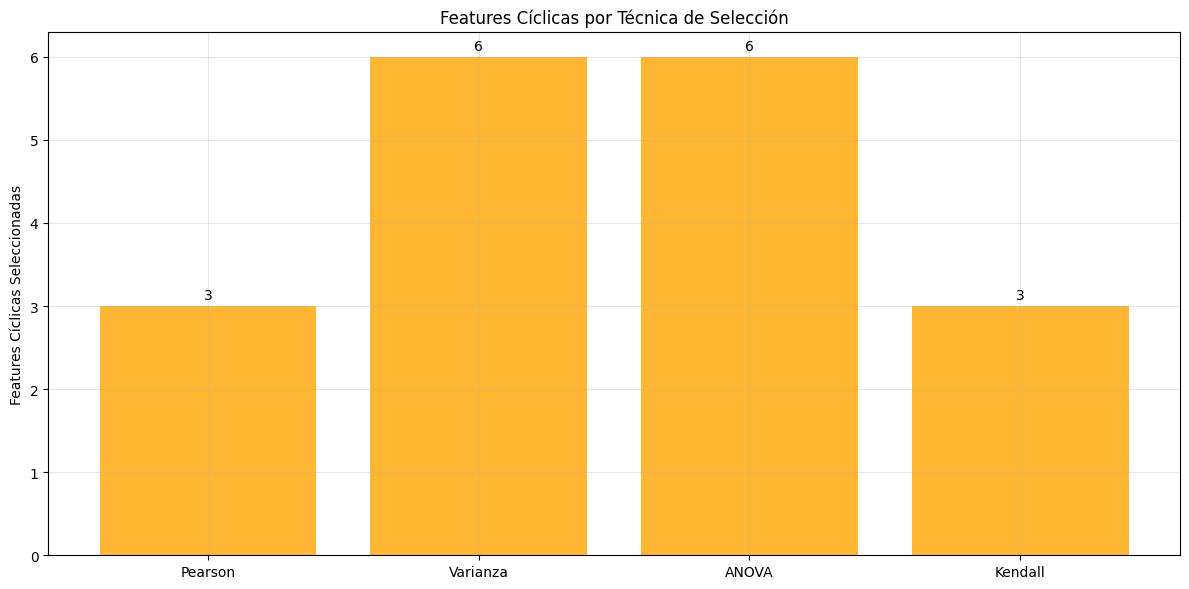

In [154]:
# GRÁFICO 4: Features cíclicas seleccionadas por técnica
plt.figure(figsize=(12, 6))
ciclicas_counts = [len(ciclicas_en_pearson), len(ciclicas_en_varianza), 
                  len(ciclicas_en_anova), len(ciclicas_en_kendall)]
tecnicas_seleccion = ['Pearson', 'Varianza', 'ANOVA', 'Kendall']

bars_ciclicas = plt.bar(tecnicas_seleccion, ciclicas_counts, color='orange', alpha=0.8)
plt.ylabel('Features Cíclicas Seleccionadas')
plt.title('Features Cíclicas por Técnica de Selección')
plt.grid(True, alpha=0.3)

# Agregar números encima de las barras
for bar in bars_ciclicas:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()